#### Import required packages  


24-nov
    - add dbscan to basic clustering ...




<a name='toc'></a>  TOC

* <a href='#me.01.t1'> Modeling and Evaluation 1</a> :
            Train and adjust parameters  
            
  - <a href='#k-means'>K-Means</a>
  - <a href='#end_of_file'> end of file</a>


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time
import copy

from pylab import rcParams
#import hdbscan

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn import metrics
from sklearn import metrics as mt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.cluster import KMeans

from tabulate import tabulate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from __future__ import print_function

#### Read in cleaned  dataset from .csv file  

In [3]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... read in cleaned data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

data_dir = '../data/'
data_file = 'mashable_clean_dataset_for_lab_03.csv'

file_2_read = data_dir + data_file
df = pd.read_csv(file_2_read)

df_cluster = copy.deepcopy(df)

df_cluster.head()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... add 'popular' binary based 'shares' values
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

df_cluster['shares'] = np.exp(df_cluster['ln_shares'])
df_cluster['popular'] = np.where(df_cluster['shares'] > 1400, 1, 0)

df_cluster.head()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... read in t-SNE vectors
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

data_dir = '../data/'
data_file = 't_sne_mapping_perplex_0075.csv'

file_2_read = data_dir + data_file
df_tsne = pd.read_csv(file_2_read)

df_tsne.head()

n_tokens_title  num_keywords  data_channel_is_lifestyle  \
0              12             5                          0   
1               9             4                          0   
2               9             6                          0   
3               9             7                          0   
4              13             7                          0   

   data_channel_is_entertainment  data_channel_is_socmed  kw_avg_max  \
0                              1                       0    1.800304   
1                              0                       0    1.800304   
2                              0                       0    1.800304   
3                              1                       0    1.800304   
4                              0                       0    1.800304   

   weekday_is_monday  weekday_is_tuesday  weekday_is_wednesday  \
0                  1                   0                     0   
1                  1                   0                     0   
2                  1                   0                     0   
3                  1                   0                     0   
4                  1                   0                     0   

   weekday_is_thursday    ...      ln_self_reference_avg_sharess  ln_LDA_00  \
0                    0    ...                           6.208590   0.405686   
1                    0    ...                           0.000000   0.587651   
2                    0    ...                           6.823286   0.197040   
3                    0    ...                           0.000000   0.028173   
4                    0    ...                           8.055843   0.028231   

   ln_LDA_01  ln_LDA_02  ln_LDA_03  ln_LDA_04  ln_global_rate_negative_words  \
0   0.320836   0.039225   0.040434   0.039339                       0.013606   
1   0.048835   0.048882   0.048886   0.048791                       0.015565   
2   0.032791   0.032807   0.032790   0.520096                       0.009434   
3   0.350164   0.401893   0.028495   0.028171                       0.020504   
4   0.028387   0.028175   0.028171   0.634154                       0.012054   

   ln_min_positive_polarity  ln_abs_title_sentiment_polarity  ln_shares  
0                  0.095310                         0.171850   6.385194  
1                  0.032790                         0.000000   6.566672  
2                  0.095310                         0.000000   7.313220  
3                  0.127833                         0.000000   7.090077  
4                  0.032790                         0.127833   6.224558  

[5 rows x 38 columns]

n_tokens_title  num_keywords  data_channel_is_lifestyle  \
0              12             5                          0   
1               9             4                          0   
2               9             6                          0   
3               9             7                          0   
4              13             7                          0   

   data_channel_is_entertainment  data_channel_is_socmed  kw_avg_max  \
0                              1                       0    1.800304   
1                              0                       0    1.800304   
2                              0                       0    1.800304   
3                              1                       0    1.800304   
4                              0                       0    1.800304   

   weekday_is_monday  weekday_is_tuesday  weekday_is_wednesday  \
0                  1                   0                     0   
1                  1                   0                     0   
2                  1                   0                     0   
3                  1                   0                     0   
4                  1                   0                     0   

   weekday_is_thursday   ...     ln_LDA_01  ln_LDA_02  ln_LDA_03  ln_LDA_04  \
0                    0   ...      0.320836   0.039225   0.040434   0.039339   
1                    0   ...      0.048835   0.048882   0.048886   0.048791   
2                    0   ...      0.032791   0.032807   0.032790   0.520096   
3                    0   ...      0.350164   0.401893   0.028495   0.028171   
4                    0   ...      0.028387   0.028175   0.028171   0.634154   

   ln_global_rate_negative_words  ln_min_positive_polarity  \
0                       0.013606                  0.095310   
1                       0.015565                  0.032790   
2                       0.009434                  0.095310   
3                       0.020504                  0.127833   
4                       0.012054                  0.032790   

   ln_abs_title_sentiment_polarity  ln_shares  shares  popular  
0                         0.171850   6.385194   593.0        0  
1                         0.000000   6.566672   711.0        0  
2                         0.000000   7.313220  1500.0        1  
3                         0.000000   7.090077  1200.0        0  
4                         0.127833   6.224558   505.0        0  

[5 rows x 40 columns]

x-tsne     y-tsne  sample_index
0  -7.965860  13.762158         35730
1   8.008342 -24.209244         21250
2  10.905466 -25.578592         10815
3   0.494974 -10.806025          2036
4  -4.782010  17.363892          4875

In [4]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... join t-sne vectors with base data, since we sampled to create
# ...     the t-sne mapping
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

df_join = df_tsne.join(df_cluster, on = 'sample_index')

df_join.head()


x-tsne     y-tsne  sample_index  n_tokens_title  num_keywords  \
0  -7.965860  13.762158         35730              11             8   
1   8.008342 -24.209244         21250              10            10   
2  10.905466 -25.578592         10815              12             9   
3   0.494974 -10.806025          2036              12             7   
4  -4.782010  17.363892          4875               7             6   

   data_channel_is_lifestyle  data_channel_is_entertainment  \
0                          0                              0   
1                          0                              0   
2                          0                              0   
3                          0                              1   
4                          0                              0   

   data_channel_is_socmed  kw_avg_max  weekday_is_monday   ...     ln_LDA_01  \
0                       0    2.409509                  0   ...      0.024693   
1                       0    1.046237                  0   ...      0.277616   
2                       0    2.302469                  0   ...      0.227070   
3                       0    0.243058                  1   ...      0.449269   
4                       1    1.290009                  0   ...      0.032797   

   ln_LDA_02  ln_LDA_03  ln_LDA_04  ln_global_rate_negative_words  \
0   0.641853   0.024693   0.024694                       0.016173   
1   0.111746   0.020974   0.419096                       0.011594   
2   0.021980   0.517849   0.021980                       0.020451   
3   0.028220   0.029072   0.156818                       0.034368   
4   0.032934   0.032951   0.427243                       0.006920   

   ln_min_positive_polarity  ln_abs_title_sentiment_polarity  ln_shares  \
0                  0.139762                         0.000000   6.591674   
1                  0.095310                         0.300105   7.600902   
2                  0.182322                         0.000000   6.350886   
3                  0.095310                         0.405465  10.218298   
4                  0.032790                         0.127833   8.411833   

    shares  popular  
0    729.0        0  
1   2000.0        1  
2    573.0        0  
3  27400.0        1  
4   4500.0        1  

[5 rows x 43 columns]

In [5]:

col_names = df_join.columns.values.tolist()
col_names
df_join.describe().T


['x-tsne',
 'y-tsne',
 'sample_index',
 'n_tokens_title',
 'num_keywords',
 'data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_socmed',
 'kw_avg_max',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'is_weekend',
 'global_subjectivity',
 'global_rate_positive_words',
 'rate_positive_words',
 'max_positive_polarity',
 'min_negative_polarity',
 'max_negative_polarity',
 'title_sentiment_polarity',
 'abs_title_subjectivity',
 'ln_n_tokens_content',
 'ln_num_hrefs',
 'ln_num_imgs',
 'ln_num_videos',
 'ln_kw_min_min',
 'ln_kw_avg_min',
 'ln_kw_min_max',
 'ln_kw_avg_avg',
 'ln_self_reference_avg_sharess',
 'ln_LDA_00',
 'ln_LDA_01',
 'ln_LDA_02',
 'ln_LDA_03',
 'ln_LDA_04',
 'ln_global_rate_negative_words',
 'ln_min_positive_polarity',
 'ln_abs_title_sentiment_polarity',
 'ln_shares',
 'shares',
 'popular']

count          mean           std        min  \
x-tsne                           793.0      0.183763      7.626268 -15.595435   
y-tsne                           793.0     -1.206435     16.407313 -26.931299   
sample_index                     793.0  19845.110971  11388.269001   6.000000   
n_tokens_title                   793.0     10.281211      2.054894   4.000000   
num_keywords                     793.0      7.172762      1.921217   1.000000   
data_channel_is_lifestyle        793.0      0.049180      0.216381   0.000000   
data_channel_is_entertainment    793.0      0.177806      0.382590   0.000000   
data_channel_is_socmed           793.0      0.060530      0.238616   0.000000   
kw_avg_max                       793.0      1.972442      1.040902   0.033629   
weekday_is_monday                793.0      0.180328      0.384703   0.000000   
weekday_is_tuesday               793.0      0.160151      0.366978   0.000000   
weekday_is_wednesday             793.0      0.194199      0.395833   0.000000   
weekday_is_thursday              793.0      0.192938      0.394854   0.000000   
weekday_is_friday                793.0      0.136192      0.343208   0.000000   
is_weekend                       793.0      0.136192      0.343208   0.000000   
global_subjectivity              793.0      0.437190      0.123485   0.000000   
global_rate_positive_words       793.0      0.038617      0.017561   0.000000   
rate_positive_words              793.0      0.674298      0.206946   0.000000   
max_positive_polarity            793.0      0.754020      0.257457   0.000000   
min_negative_polarity            793.0      0.492651      0.294524   0.000000   
max_negative_polarity            793.0      0.894358      0.093398   0.000000   
title_sentiment_polarity         793.0      1.084097      0.263788   0.000000   
abs_title_subjectivity           793.0      0.347141      0.187727   0.000000   
ln_n_tokens_content              793.0      5.803464      1.355099   0.000000   
ln_num_hrefs                     793.0      2.135702      0.819271   0.000000   
ln_num_imgs                      793.0      1.087727      0.971917   0.000000   
ln_num_videos                    793.0      0.410081      0.708919   0.000000   
ln_kw_min_min                    793.0      1.175961      1.703421   0.000000   
ln_kw_avg_min                    793.0      5.247673      1.123600   0.000000   
ln_kw_min_max                    793.0      5.107195      4.583003   0.000000   
ln_kw_avg_avg                    793.0      7.980799      0.520308   0.000000   
ln_self_reference_avg_sharess    793.0      6.685791      3.251447   0.000000   
ln_LDA_00                        793.0      0.140598      0.187981   0.019803   
ln_LDA_01                        793.0      0.115194      0.160471   0.019803   
ln_LDA_02                        793.0      0.161589      0.202394   0.019803   
ln_LDA_03                        793.0      0.179587      0.220060   0.019803   
ln_LDA_04                        793.0      0.203096      0.224544   0.019803   
ln_global_rate_negative_words    793.0      0.016649      0.012614   0.000000   
ln_min_positive_polarity         793.0      0.091944      0.065461   0.000000   
ln_abs_title_sentiment_polarity  793.0      0.129274      0.175148   0.000000   
ln_shares                        793.0      7.466504      0.946505   3.988984   
shares                           793.0   3464.713745   8200.162279  54.000000   
popular                          793.0      0.490542      0.500226   0.000000   

                                          25%           50%           75%  \
x-tsne                              -6.016733     -0.520249      7.248261   
y-tsne                             -19.782446      3.213885     14.054019   
sample_index                     10119.000000  19294.000000  29842.000000   
n_tokens_title                       9.000000     10.000000     12.000000   
num_keywords                         6.000000      7.000000      9.000000   
data_c

In [6]:
# set required variables for model comparison

kmeans_tbl = pd.DataFrame(columns = [
    'model_name',
    'n_clusters',
    'inertia',
    'silhouette',
    'process_time'])

i_index = []
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

<a href='#toc'> Table of Contents</a>

<a name='k-means'></a>
<font color="blue" size=3>K-Means

### K-Means  



n_lda =  2


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  41053.6758813
silhouette =  0.723871578321
0 -4.98351347578 12.3628425402 0
1 6.92826091458 -18.9174969085 1


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


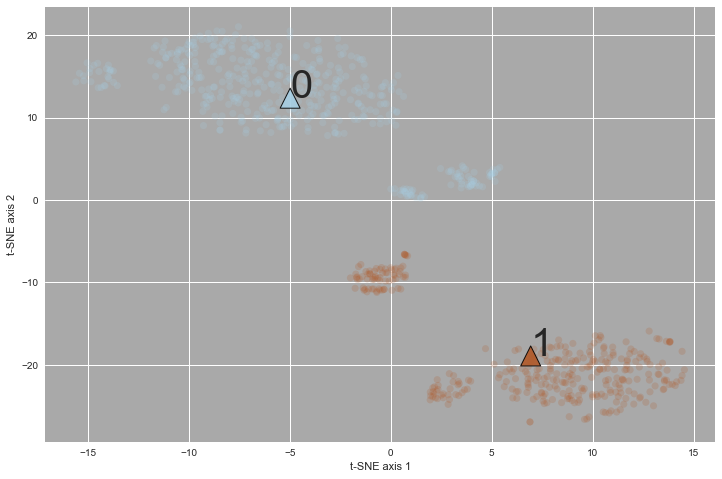

n_lda =  3


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  18820.3152961
silhouette =  0.681495585269
0 -6.42113416938 14.2287517246 0
1 8.88779712468 -21.4714582422 1
2 1.19343525135 -3.71199751408 2


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


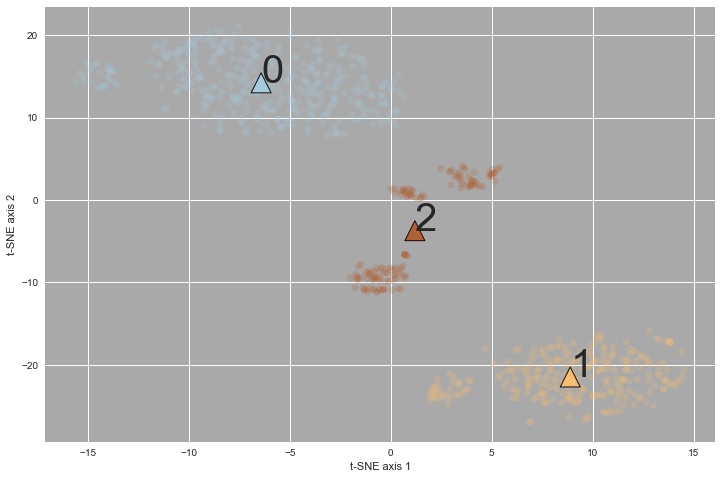

n_lda =  4


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  13845.1005382
silhouette =  0.647769859655
0 -6.48832503963 14.280547837 0
1 8.88779712468 -21.4714582422 1
2 -0.474431434695 -9.26919853687 2
3 2.76729677088 2.48534676473 3


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


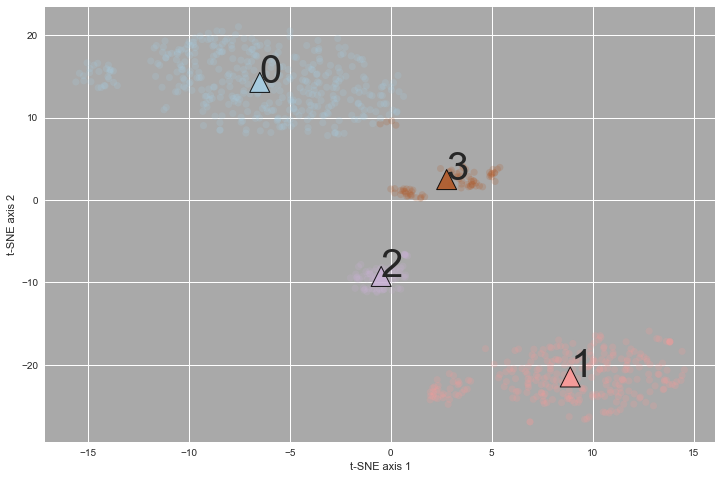

n_lda =  5


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  9349.25652705
silhouette =  0.57540471924
0 -9.58949389202 16.4568792809 0
1 8.88779712468 -21.4714582422 1
2 2.93381788027 2.0868209445 2
3 -3.91035854011 12.4630657367 3
4 -0.474431434695 -9.26919853687 4


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


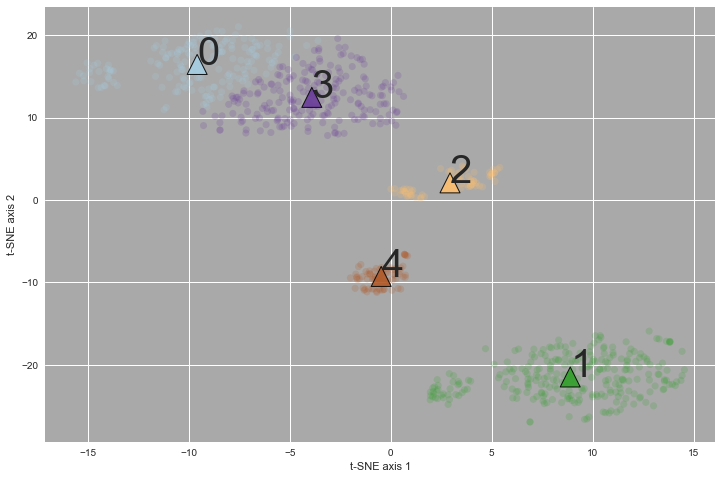

n_lda =  6


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  7439.56550342
silhouette =  0.471987750489
0 -3.89964579953 12.4496273565 0
1 5.98727052085 -22.6817051541 1
2 -0.474431434695 -9.26919853687 2
3 2.93381788027 2.0868209445 3
4 -9.56926461931 16.450025344 4
5 10.949177667 -20.611345657 5


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


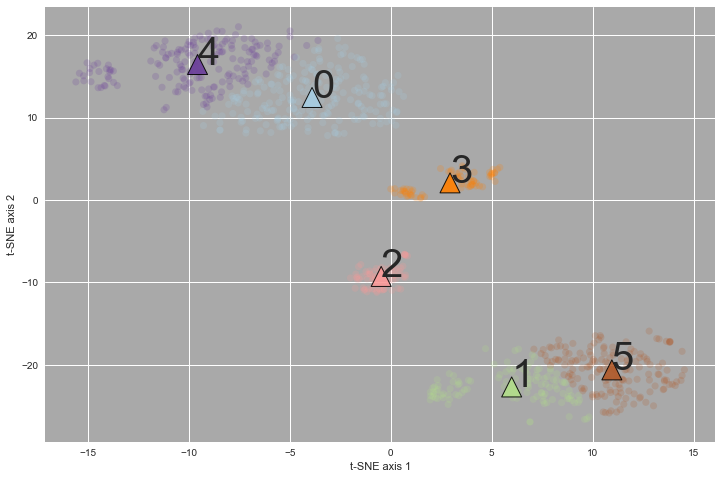

n_lda =  7


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  6179.82296345
silhouette =  0.448528403336
0 -5.8966634199 17.2701912607 0
1 11.0109187609 -20.6278601121 1
2 2.93381788027 2.0868209445 2
3 -0.474431434695 -9.26919853687 3
4 -11.0346427743 15.3636428576 4
5 6.03256457941 -22.6059522793 5
6 -3.85366971222 11.4319840059 6


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


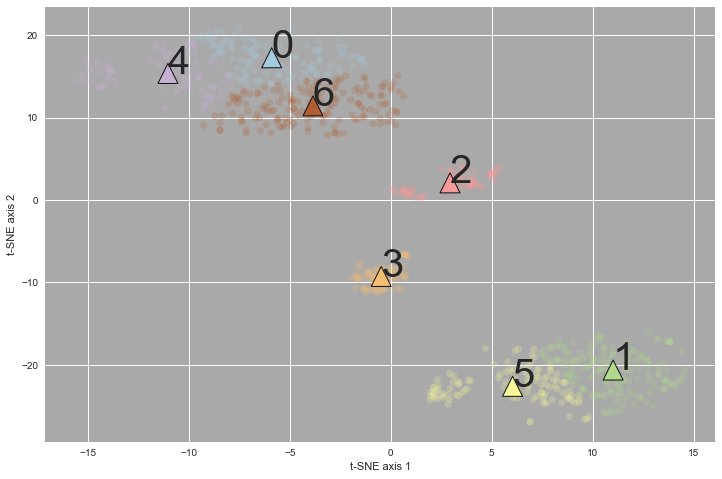

n_lda =  8


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  5278.29705895
silhouette =  0.446502751107
0 -2.11195218068 12.3461174598 0
1 5.89088834644 -22.7018323251 1
2 2.93381788027 2.0868209445 2
3 -6.32402556352 17.5694075401 3
4 -0.474431434695 -9.26919853687 4
5 10.891864958 -20.6486927512 5
6 -6.83764923349 11.382025057 6
7 -11.6989848342 16.05214731 7


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


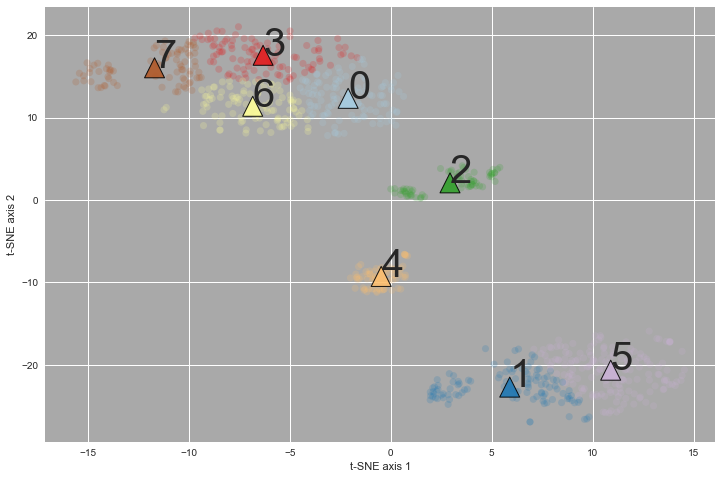

n_lda =  9


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  4455.54989726
silhouette =  0.449633957471
0 11.0482299938 -23.2619126342 0
1 -2.03405432912 12.0268717414 1
2 2.93381788027 2.0868209445 2
3 5.17758031873 -22.5906617557 3
4 -11.5526624521 16.1992503461 4
5 -0.474431434695 -9.26919853687 5
6 -6.83794390528 11.2876566234 6
7 10.1706803105 -19.0050089713 7
8 -5.91290100116 17.276494638 8


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


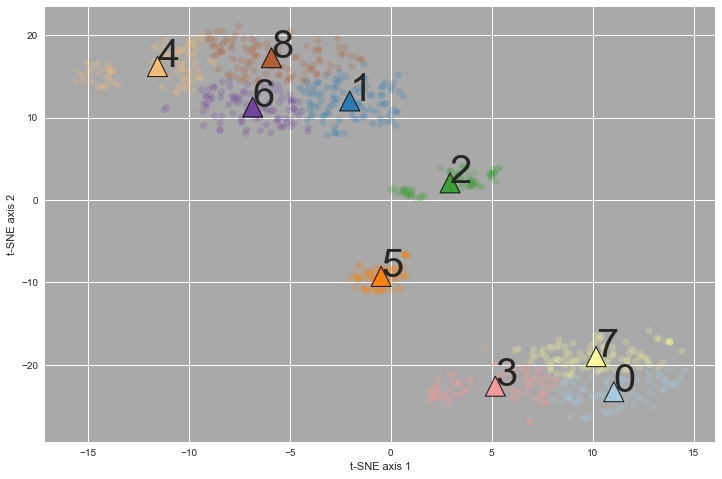

n_lda =  10


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  3890.70125893
silhouette =  0.460950200867
0 -8.65683299562 18.0380604785 0
1 10.9828950383 -23.2379798889 1
2 -0.474431434695 -9.26919853687 2
3 -2.96659179823 10.6056506446 3
4 2.93381788027 2.0868209445 4
5 -7.90896589836 12.4407120501 5
6 -3.11582573026 15.5005285649 6
7 10.1706803105 -19.0050089713 7
8 5.1053896769 -22.5998615127 8
9 -13.8557251961 15.2179372541 9


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


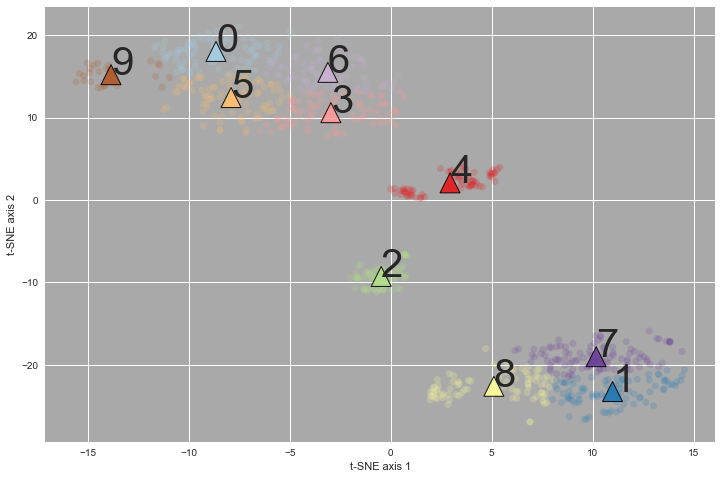

n_lda =  11


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=11, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  3404.36808875
silhouette =  0.457774179978
0 7.72855682749 -20.1429939019 0
1 -8.84976030706 17.8189012507 1
2 2.93381788027 2.0868209445 2
3 -6.87141961194 11.347862758 3
4 -0.474431434695 -9.26919853687 4
5 -1.90000799251 11.3596154332 5
6 3.36871406294 -23.0513903754 6
7 9.75087239037 -24.0202060485 7
8 12.0037658875 -19.7081455438 8
9 -4.03056758956 16.0341831759 9
10 -12.8368789716 14.7290613651 10


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


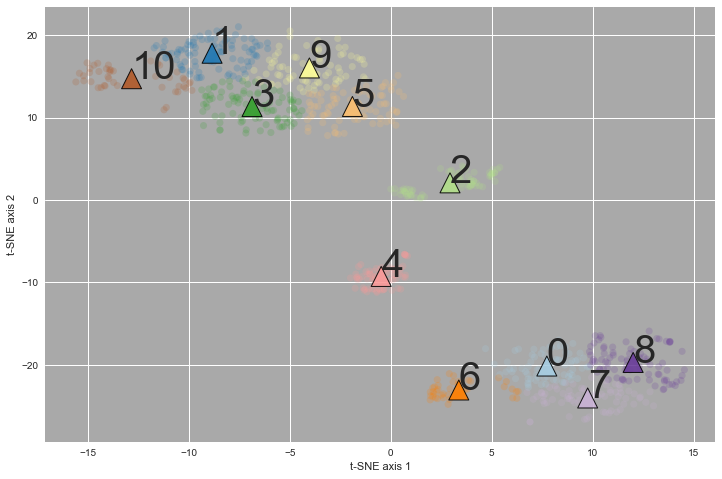

n_lda =  12


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  3007.49702638
silhouette =  0.468635425575
0 -8.5667883664 13.7149739331 0
1 7.71706420263 -20.1163159434 1
2 -0.474431434695 -9.26919853687 2
3 -1.40226466822 12.0914009639 3
4 2.93381788027 2.0868209445 4
5 -3.91845201162 16.3130578114 5
6 12.0187363741 -19.6828048636 6
7 -5.32785253843 10.1972415924 7
8 3.36871406294 -23.0513903754 8
9 9.74902232053 -23.9638979664 9
10 -8.86383251826 18.3418809509 10
11 -14.0426551556 15.2824603114 11


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


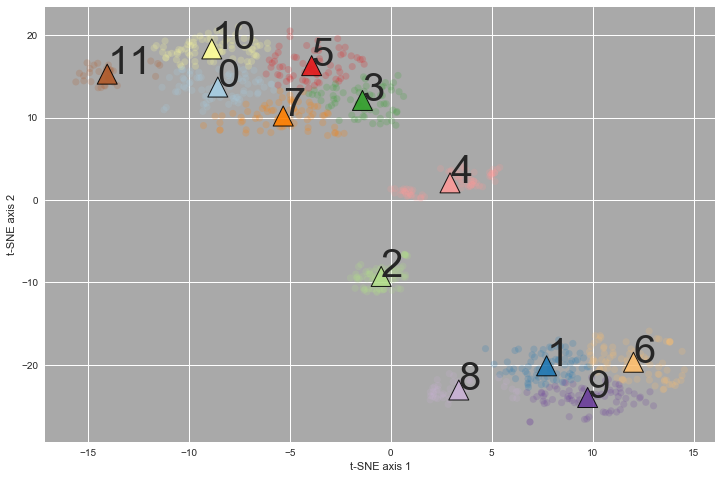

n_lda =  13


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=13, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  2734.16354398
silhouette =  0.468812335787
0 11.9131218592 -23.1020567375 0
1 -5.40208379082 10.062734051 1
2 -0.474431434695 -9.26919853687 2
3 -8.90170822515 18.2763015945 3
4 2.93381788027 2.0868209445 4
5 7.75989109675 -19.64469045 5
6 -3.85329117775 16.3285006303 6
7 -8.41843931095 13.626934 7
8 -14.0426551556 15.2824603114 8
9 -1.53318536946 12.0058299556 9
10 11.6356504599 -18.8555410226 10
11 2.83779408932 -23.0284757887 11
12 7.92295975685 -23.456814448 12


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


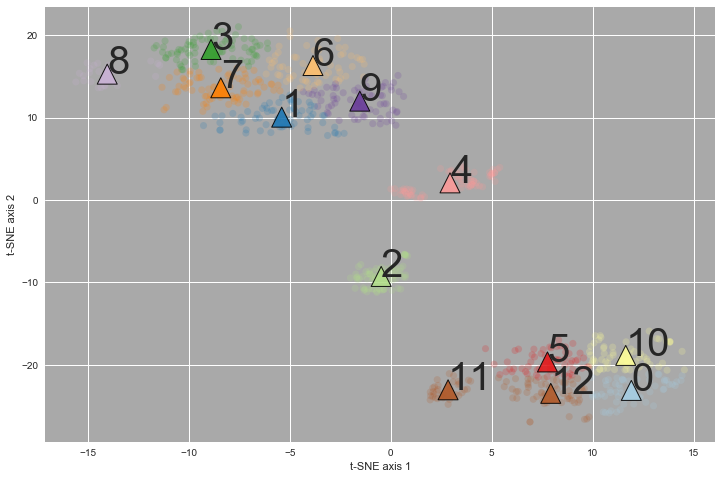

n_lda =  14


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=14, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  2547.19096447
silhouette =  0.456097089234
0 -8.72179488647 18.3933557853 0
1 8.82965800497 -18.6885710116 1
2 0.860980757696 0.848722333709 2
3 -1.5979303623 11.4591664414 3
4 -0.474431434695 -9.26919853687 4
5 -5.7417543767 10.2554634034 5
6 10.6475750958 -24.0102043505 6
7 2.76419969517 -23.0712256151 7
8 7.27265597101 -22.253604348 8
9 -8.5667883664 13.7149739331 9
10 -14.0426551556 15.2824603114 10
11 -3.69037961364 15.9143015998 11
12 4.0393310123 2.74714020358 12
13 12.4517379488 -19.9855493667 13


/home/mcdevitt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


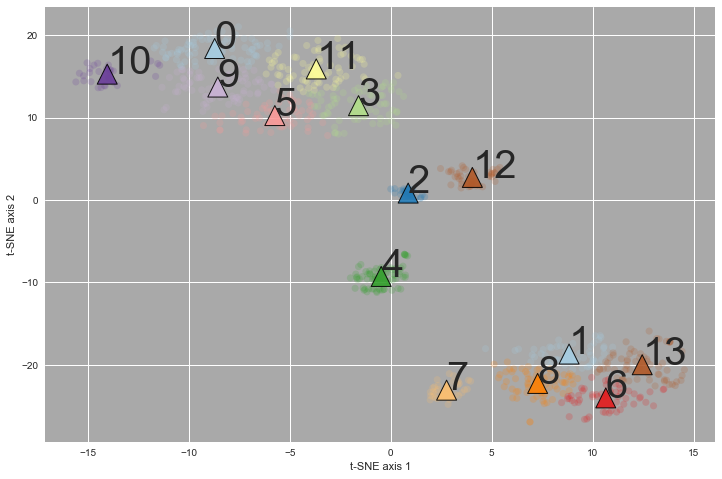

In [7]:
# ... k-means on the t-sne vectors

X_tsne = pd.DataFrame(columns=['t1', 't2'])
X_tsne['t1'] = df_join['x-tsne']
X_tsne['t2'] = df_join['y-tsne']

for n_lda in range(2, 15):  

    tic = time.clock()
    
    print ("n_lda = ", n_lda)

    cls_lda = KMeans(n_clusters = n_lda,
                     init = 'k-means++',
                     random_state = 1);
    
    cls_lda.fit(X_tsne)

    kmeans_labels = cls_lda.labels_ # the labels from kmeans clustering
    kmeans_centers = cls_lda.cluster_centers_

    kmeans_inertia = cls_lda.inertia_
    print ("inertia = ", kmeans_inertia)
    
    kmeans_silhouette = metrics.silhouette_score(X_tsne,
                                                 kmeans_labels,
                                                 metric = 'euclidean',
                                                 sample_size = 10000)
    print ("silhouette = ", kmeans_silhouette)
    
    toc =  time.clock()
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - save statistics for model comparison
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

    exe_time = '{0:.4f}'.format(toc-tic)
    
    raw_data = {
    'model_name' : 'KMeans - LDA features',
    'n_clusters' : n_lda,
    'inertia': kmeans_inertia,
    'silhouette': kmeans_silhouette, 
    'process_time' : exe_time
    }

    df_tbl = pd.DataFrame(raw_data,
    columns = ['model_name', 'n_clusters', 'inertia', 'silhouette', 'process_time'],
    index = [i_index + 1])

    kmeans_tbl = kmeans_tbl.append(df_tbl)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - make some plots of clusters
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
    
    _ = plt.figure(figsize=(12, 8));
    _ = plt.subplot(111, facecolor = 'darkgrey');
    
    X_tsne_values = X_tsne.values;
    _ = plt.scatter(X_tsne_values[:, 0], X_tsne_values[:, 1],
                c = kmeans_labels,
                cmap = plt.cm.Paired,
                s = 50,
                linewidths = 0,
                alpha = 0.20);
    _ = plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1],
                c = range(n_lda),
                cmap = plt.cm.Paired,
                s = 400,
                linewidths = 1.0,
                marker = '^',
                edgecolors = 'black',
                alpha = 0.90);
    
    for ii in range(n_lda) :                                       
        _ = plt.text(kmeans_centers[ii, 0], kmeans_centers[ii, 1], ii, fontsize = 40)
        print(ii, kmeans_centers[ii, 0], kmeans_centers[ii, 1], ii)
    
    _ = plt.xlabel('t-SNE axis 1')
    _ = plt.ylabel('t-SNE axis 2');
    _ = plt.grid(True);

    plt.show();
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - 
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-



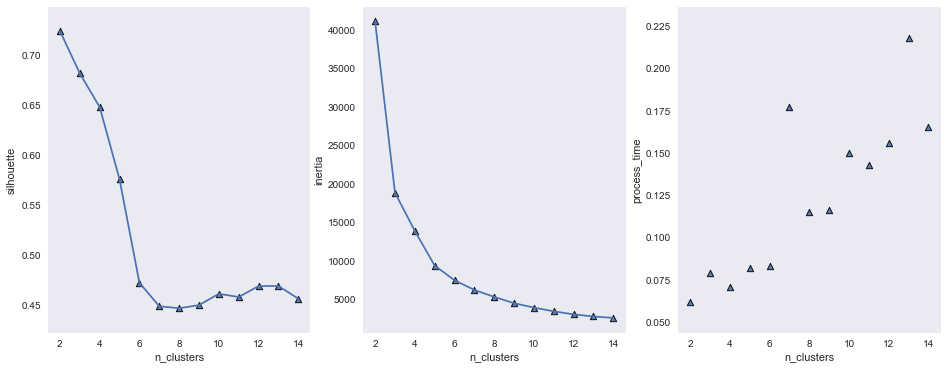

In [8]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - plot metrics across models for comparison
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

plt.figure(figsize=(16, 6));

# ... silhouette values

plt.subplot(131);
plt.scatter(kmeans_tbl['n_clusters'],
            kmeans_tbl['silhouette'],
            s = 40,
            linewidths = 1.0,
            marker = '^',
            edgecolors = 'black',
            alpha = 0.90);

plt.plot(kmeans_tbl['n_clusters'],
         kmeans_tbl['silhouette'])

plt.xlabel('n_clusters'), plt.ylabel('silhouette');
plt.grid();

# ... inertia values

plt.subplot(132);
plt.scatter(kmeans_tbl['n_clusters'],
            kmeans_tbl['inertia'],
            s = 40,
            linewidths = 1.0,
            marker = '^',
            edgecolors = 'black',
            alpha = 0.90);

plt.plot(kmeans_tbl['n_clusters'],
         kmeans_tbl['inertia'])

plt.xlabel('n_clusters'), plt.ylabel('inertia');
plt.grid();

# ... process time

plt.subplot(133);
plt.scatter(kmeans_tbl['n_clusters'],
            kmeans_tbl['process_time'],
            s = 40,
            linewidths = 1.0,
            marker = '^',
            edgecolors = 'black',
            alpha = 0.90);

#plt.plot(kmeans_tbl['n_clusters'],
#         kmeans_tbl['process_time'])

plt.xlabel('n_clusters'), plt.ylabel('process_time');
plt.grid();


plt.show();


### - choose kmeans clustering with preferred number of clusters  


n_lda =  2


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  41053.6758813
silhouette =  0.723871578321


0 -4.98351347578 12.3628425402 0


1 6.92826091458 -18.9174969085 1
[0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 0
 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1
 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1
 0 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0
 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 1 1 0 1 0 0
 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0
 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0
 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0
 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0
 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1
 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0
 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 1
 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 

(<matplotlib.text.Text at 0x7fdab4283860>,
 <matplotlib.text.Text at 0x7fdab42b1278>)

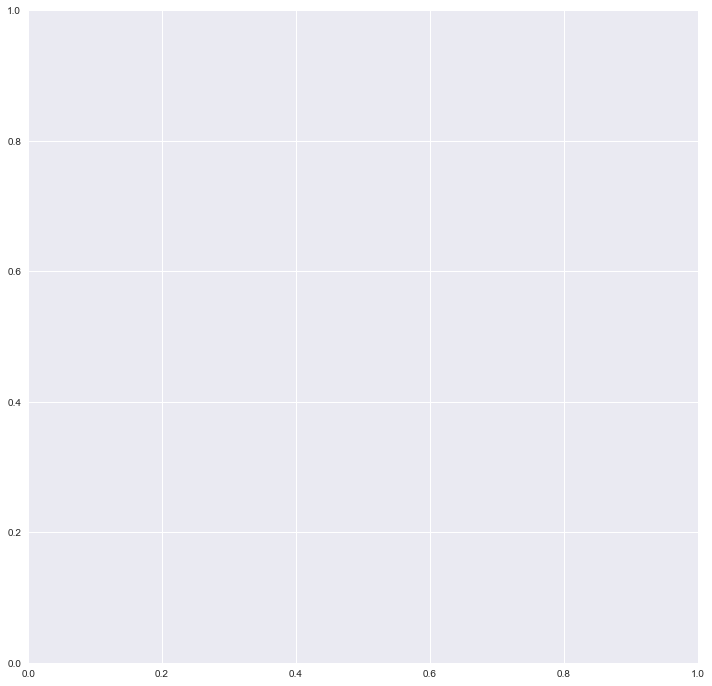

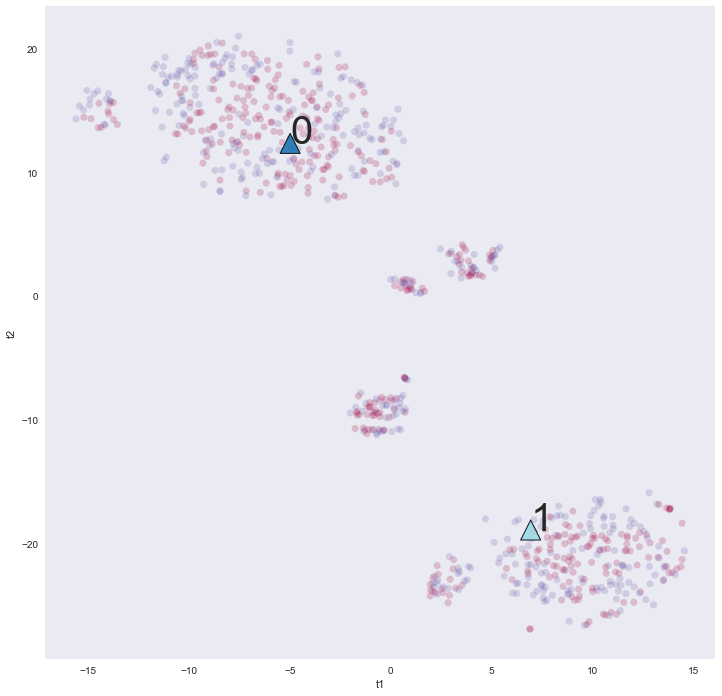

In [10]:

n_clusters_chosen = 2

for n_lda in range (n_clusters_chosen, n_clusters_chosen+1) :

    tic = time.clock()
    
    print ("n_lda = ", n_lda)

    cls_lda = KMeans(n_clusters = n_lda,
                     init = 'k-means++',
                     random_state = 1);
    
    cls_lda.fit(X_tsne)

    kmeans_labels = cls_lda.labels_ # the labels from kmeans clustering
    kmeans_centers = cls_lda.cluster_centers_

    kmeans_inertia = cls_lda.inertia_
    print ("inertia = ", kmeans_inertia)
    
    kmeans_silhouette = metrics.silhouette_score(X_tsne,
                                                 kmeans_labels,
                                                 metric = 'euclidean',
                                                 sample_size = 10000)
    print ("silhouette = ", kmeans_silhouette)
    
    toc =  time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - make some plots of clusters
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
    
    plt.figure(figsize=(12, 12));
    ax = plt.gca();
    
    X_tsne_values = X_tsne.values;
    plt.scatter(X_tsne_values[:, 0], X_tsne_values[:, 1],
                c = df_join['popular'],
                cmap = plt.cm.Spectral,
                s = 50,
                linewidths = 0,
                alpha = 0.20);
    plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1],
                c = range(n_lda),
                cmap = plt.cm.tab20,
                s = 400,
                linewidths = 1.0,
                marker = '^',
                edgecolors = 'black',
                alpha = 0.90);    
    for ii in range(n_lda) :                                       
        plt.text(kmeans_centers[ii, 0], kmeans_centers[ii, 1], ii, fontsize = 40)
        print(ii, kmeans_centers[ii, 0], kmeans_centers[ii, 1], ii)

    print(kmeans_labels)
    print(kmeans_centers)
    
    
    plt.xlabel('t1'), plt.ylabel('t2');
    plt.grid();

    plt.show();
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - print out comparison table
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-




In [13]:
len(kmeans_labels)


793

In [14]:

X_all_together = copy.deepcopy(df_join)

len(X_all_together)

X_all_together['kmeans_labels'] = kmeans_labels

X_all_together.describe().T


793

count          mean           std        min  \
x-tsne                           793.0      0.183763      7.626268 -15.595435   
y-tsne                           793.0     -1.206435     16.407313 -26.931299   
sample_index                     793.0  19845.110971  11388.269001   6.000000   
n_tokens_title                   793.0     10.281211      2.054894   4.000000   
num_keywords                     793.0      7.172762      1.921217   1.000000   
data_channel_is_lifestyle        793.0      0.049180      0.216381   0.000000   
data_channel_is_entertainment    793.0      0.177806      0.382590   0.000000   
data_channel_is_socmed           793.0      0.060530      0.238616   0.000000   
kw_avg_max                       793.0      1.972442      1.040902   0.033629   
weekday_is_monday                793.0      0.180328      0.384703   0.000000   
weekday_is_tuesday               793.0      0.160151      0.366978   0.000000   
weekday_is_wednesday             793.0      0.194199      0.395833   0.000000   
weekday_is_thursday              793.0      0.192938      0.394854   0.000000   
weekday_is_friday                793.0      0.136192      0.343208   0.000000   
is_weekend                       793.0      0.136192      0.343208   0.000000   
global_subjectivity              793.0      0.437190      0.123485   0.000000   
global_rate_positive_words       793.0      0.038617      0.017561   0.000000   
rate_positive_words              793.0      0.674298      0.206946   0.000000   
max_positive_polarity            793.0      0.754020      0.257457   0.000000   
min_negative_polarity            793.0      0.492651      0.294524   0.000000   
max_negative_polarity            793.0      0.894358      0.093398   0.000000   
title_sentiment_polarity         793.0      1.084097      0.263788   0.000000   
abs_title_subjectivity           793.0      0.347141      0.187727   0.000000   
ln_n_tokens_content              793.0      5.803464      1.355099   0.000000   
ln_num_hrefs                     793.0      2.135702      0.819271   0.000000   
ln_num_imgs                      793.0      1.087727      0.971917   0.000000   
ln_num_videos                    793.0      0.410081      0.708919   0.000000   
ln_kw_min_min                    793.0      1.175961      1.703421   0.000000   
ln_kw_avg_min                    793.0      5.247673      1.123600   0.000000   
ln_kw_min_max                    793.0      5.107195      4.583003   0.000000   
ln_kw_avg_avg                    793.0      7.980799      0.520308   0.000000   
ln_self_reference_avg_sharess    793.0      6.685791      3.251447   0.000000   
ln_LDA_00                        793.0      0.140598      0.187981   0.019803   
ln_LDA_01                        793.0      0.115194      0.160471   0.019803   
ln_LDA_02                        793.0      0.161589      0.202394   0.019803   
ln_LDA_03                        793.0      0.179587      0.220060   0.019803   
ln_LDA_04                        793.0      0.203096      0.224544   0.019803   
ln_global_rate_negative_words    793.0      0.016649      0.012614   0.000000   
ln_min_positive_polarity         793.0      0.091944      0.065461   0.000000   
ln_abs_title_sentiment_polarity  793.0      0.129274      0.175148   0.000000   
ln_shares                        793.0      7.466504      0.946505   3.988984   
shares                           793.0   3464.713745   8200.162279  54.000000   
popular                          793.0      0.490542      0.500226   0.000000   
kmeans_labels                    793.0      0.433796      0.495910   0.000000   

                                          25%           50%           75%  \
x-tsne                              -6.016733     -0.520249      7.248261   
y-tsne                             -19.782446      3.213885     14.054019   
sample_index                     10119.000000  19294.000000  29842.000000   
n_tokens_title                       9.000000     10.000000     12.000000   
nu

In [15]:
col_names = X_all_together.columns.values.tolist()


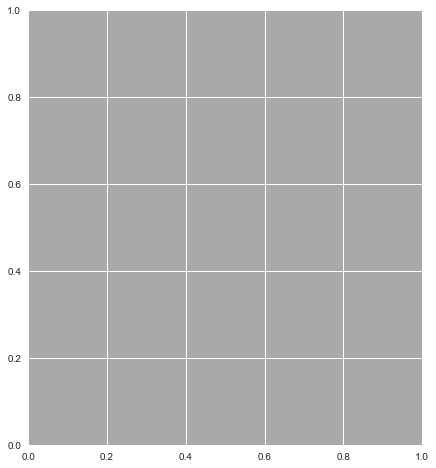

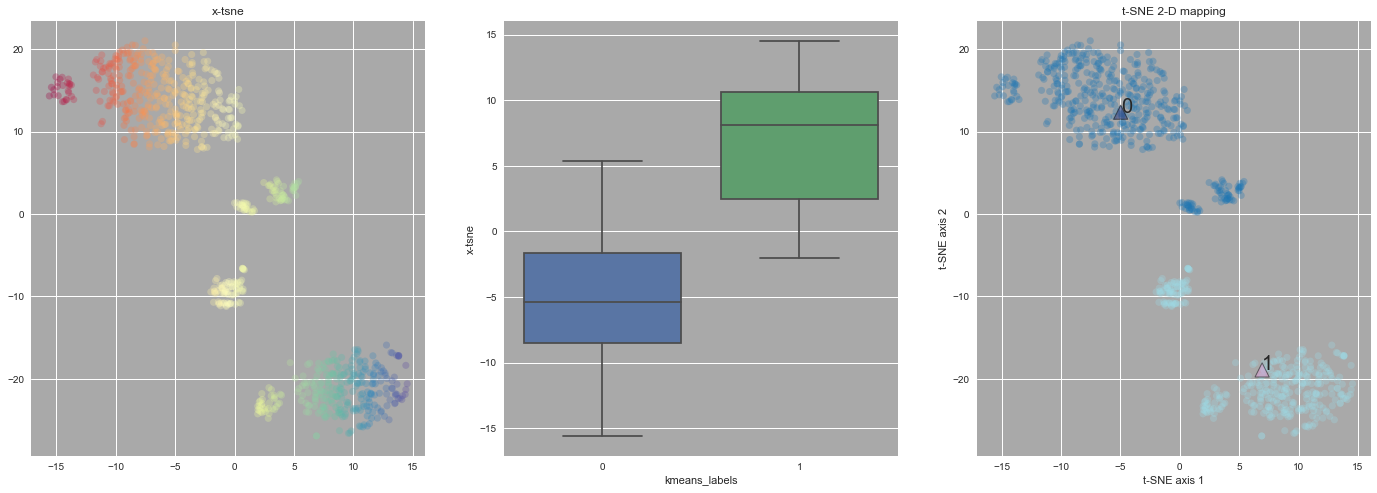

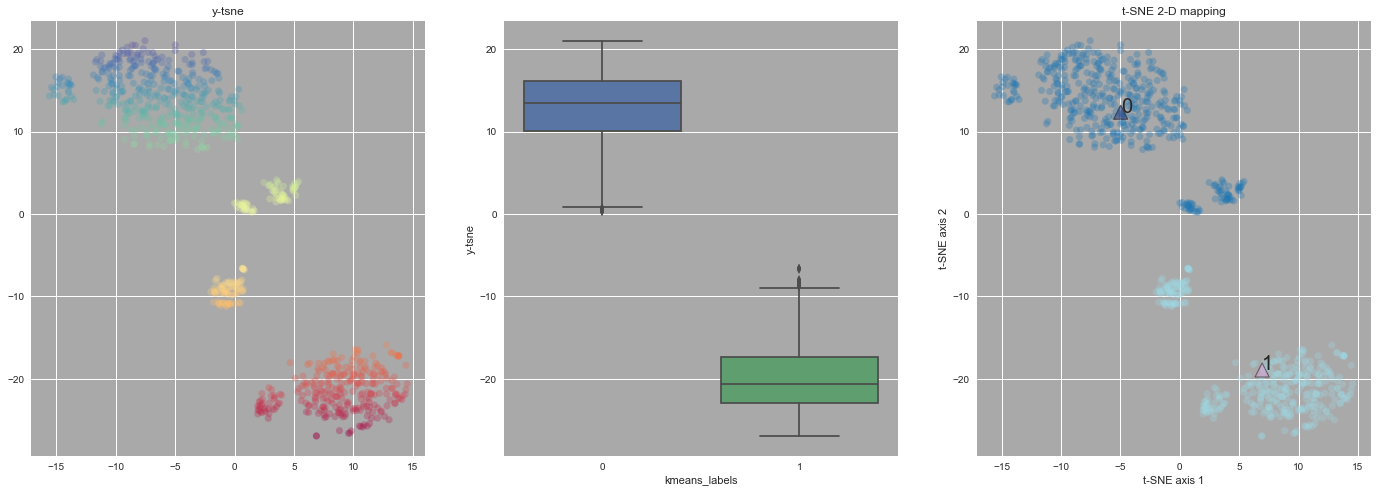

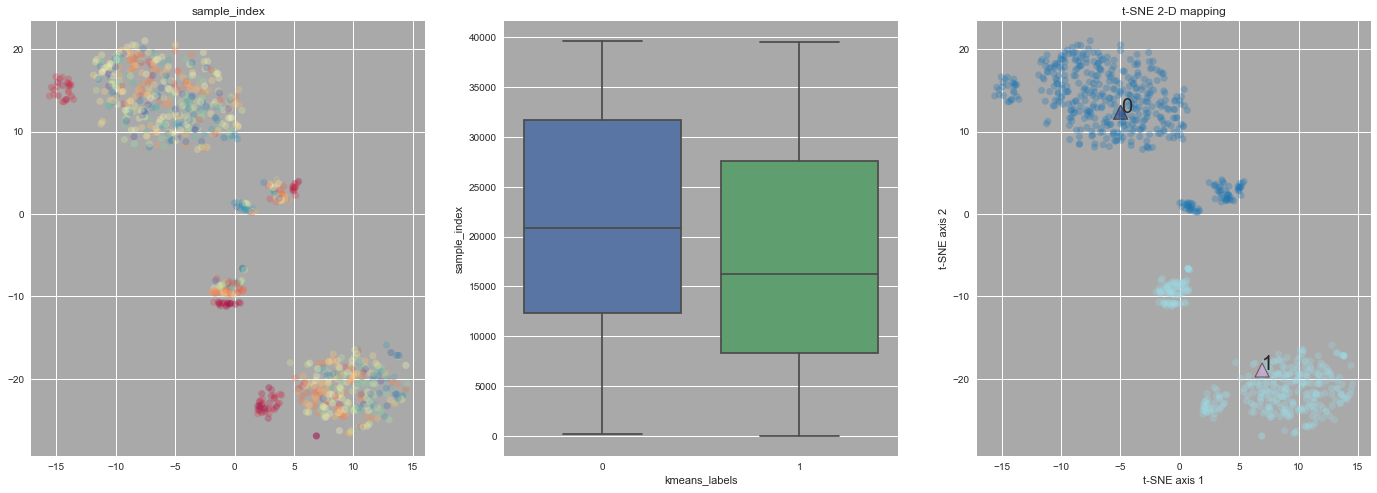

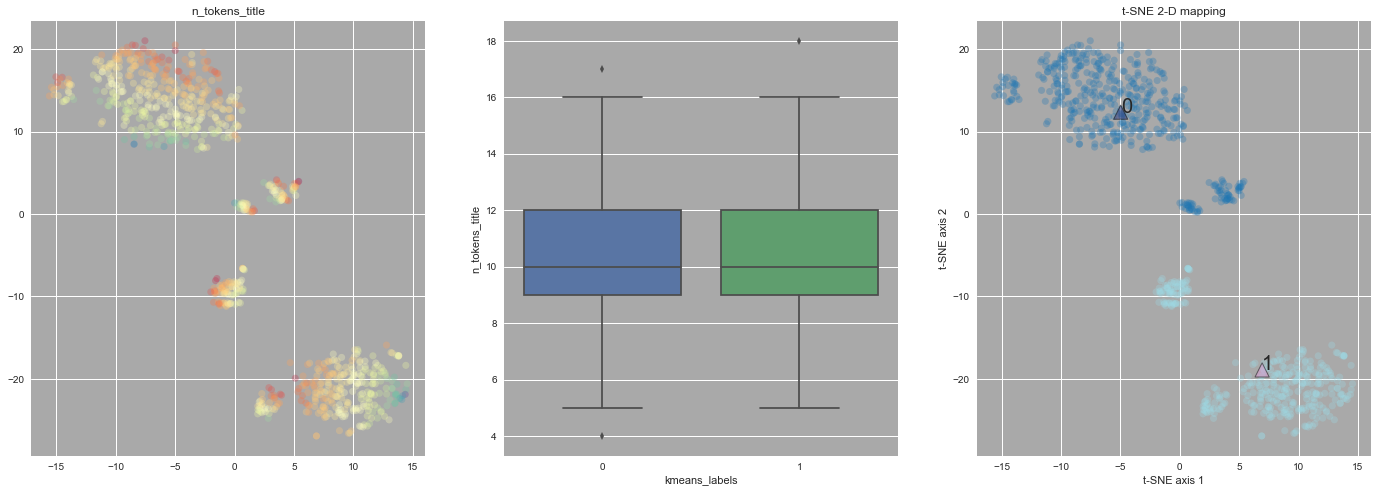

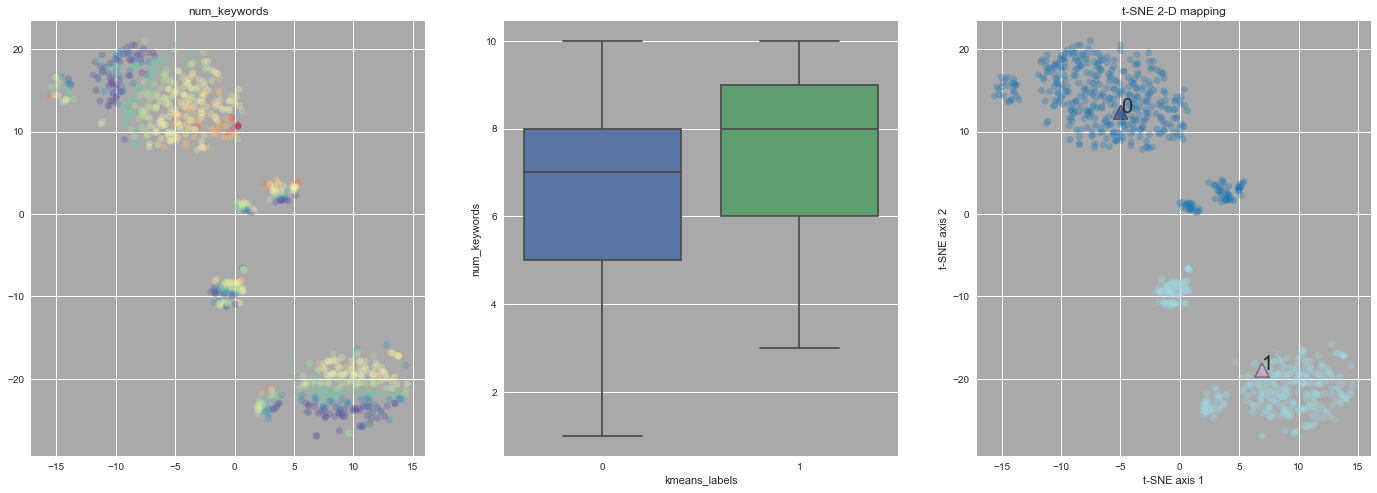

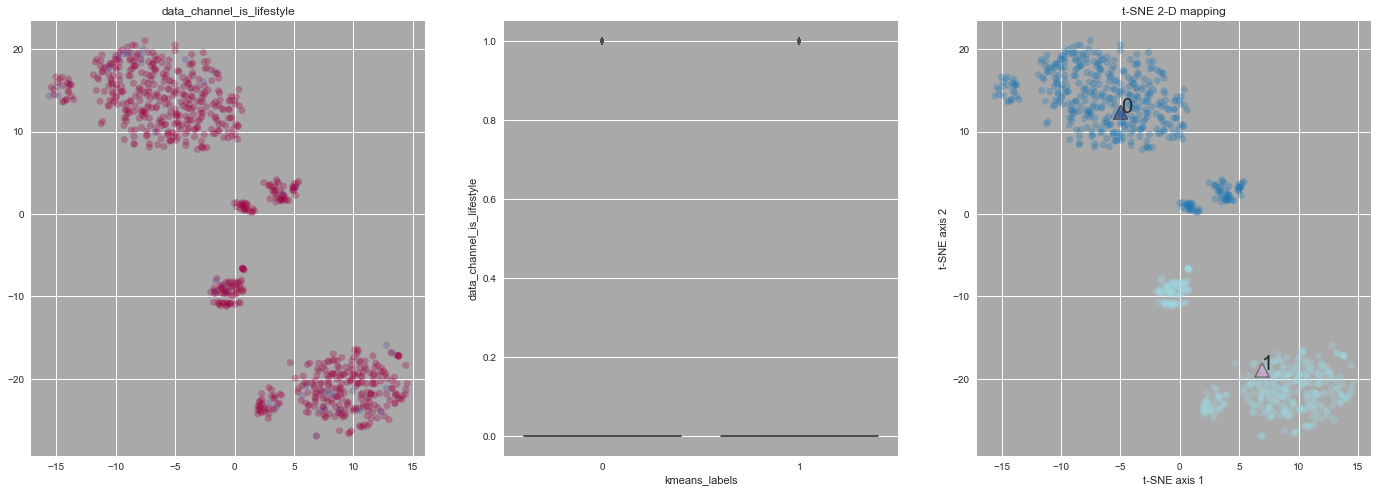

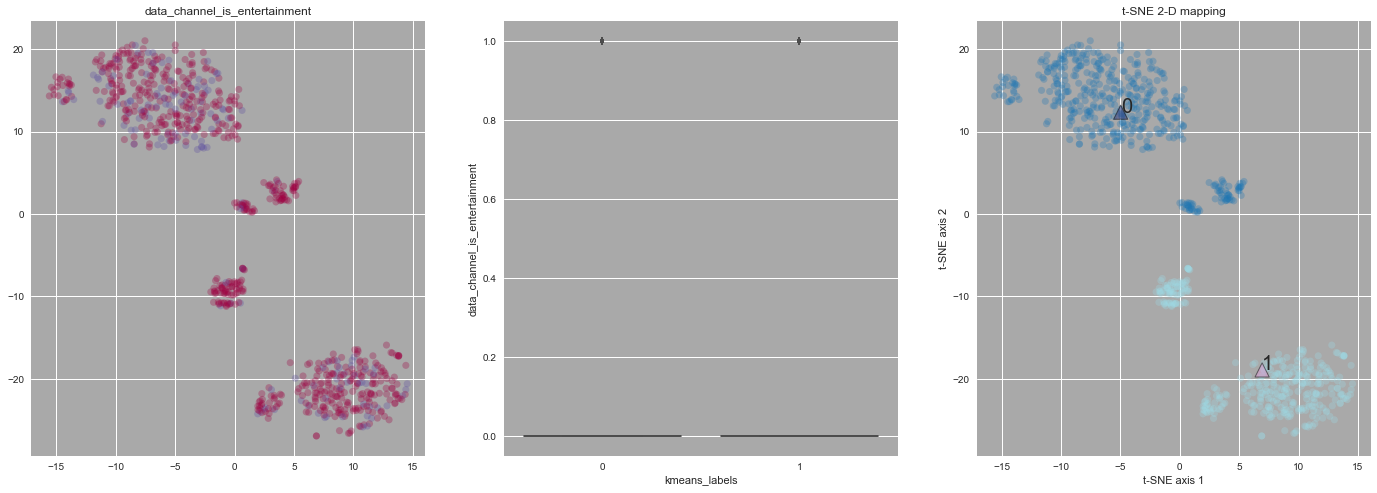

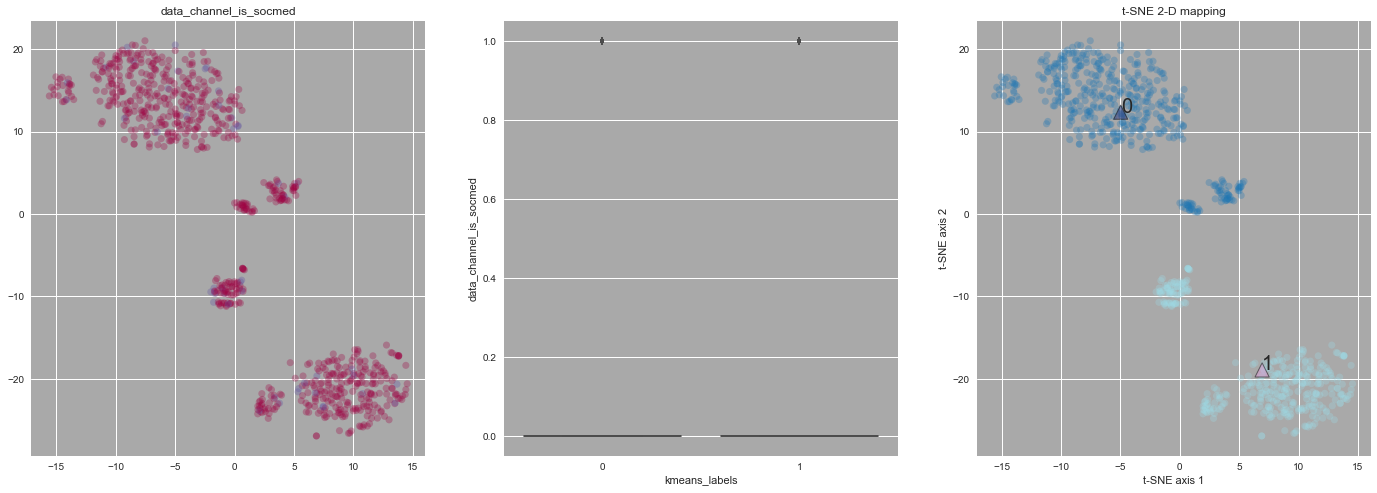

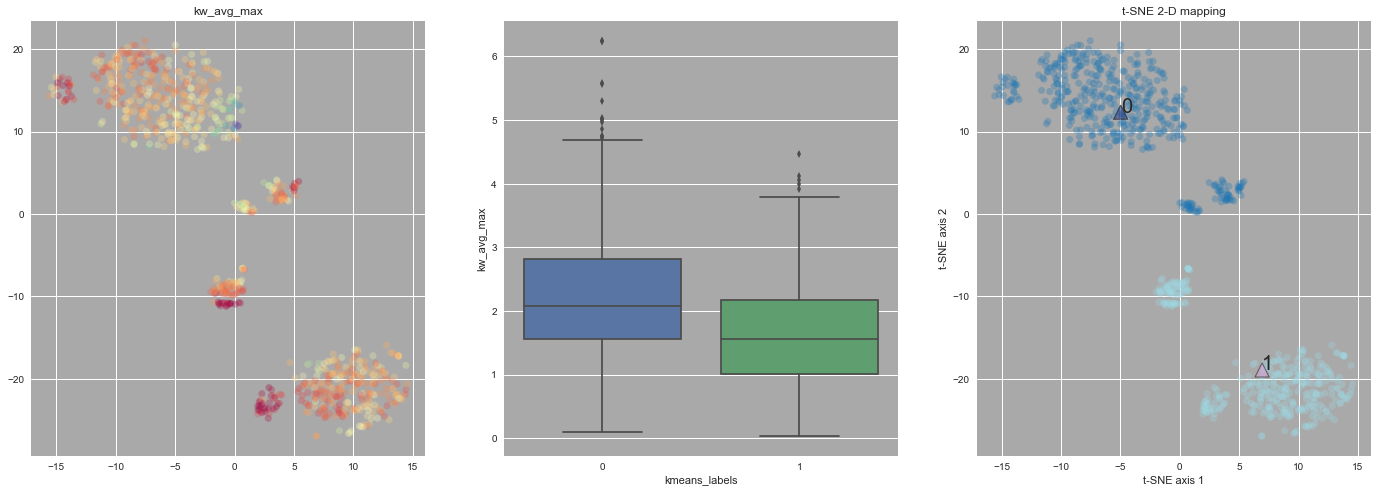

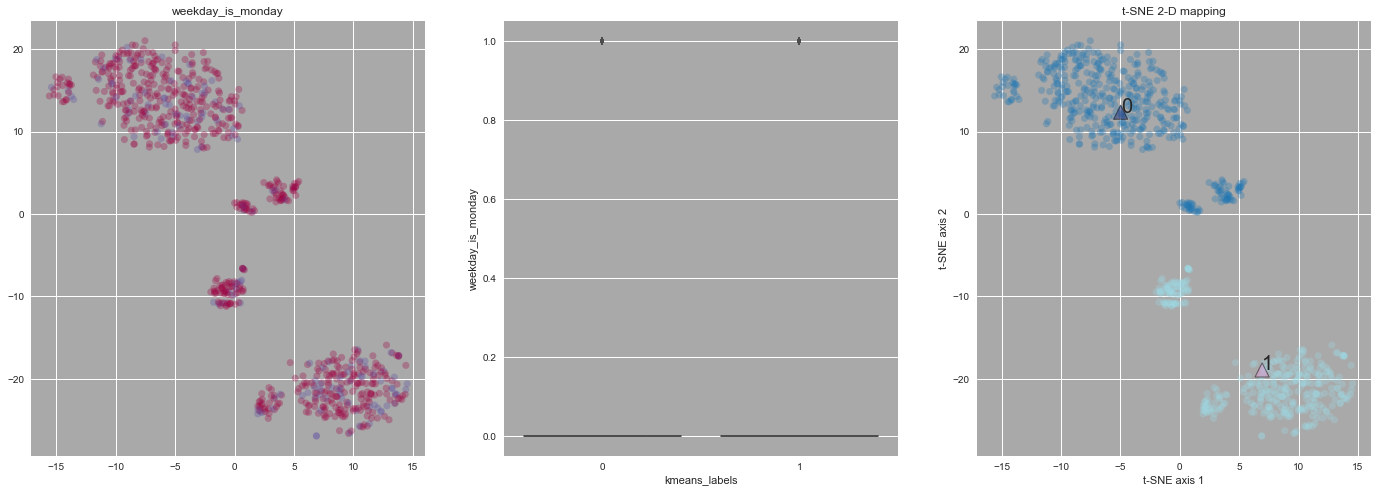

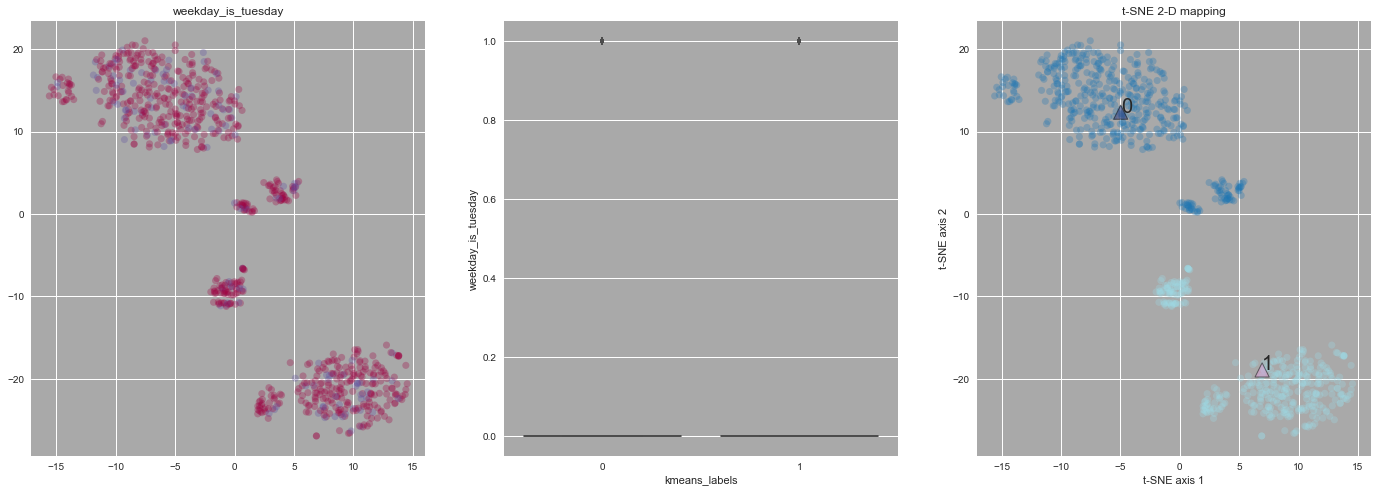

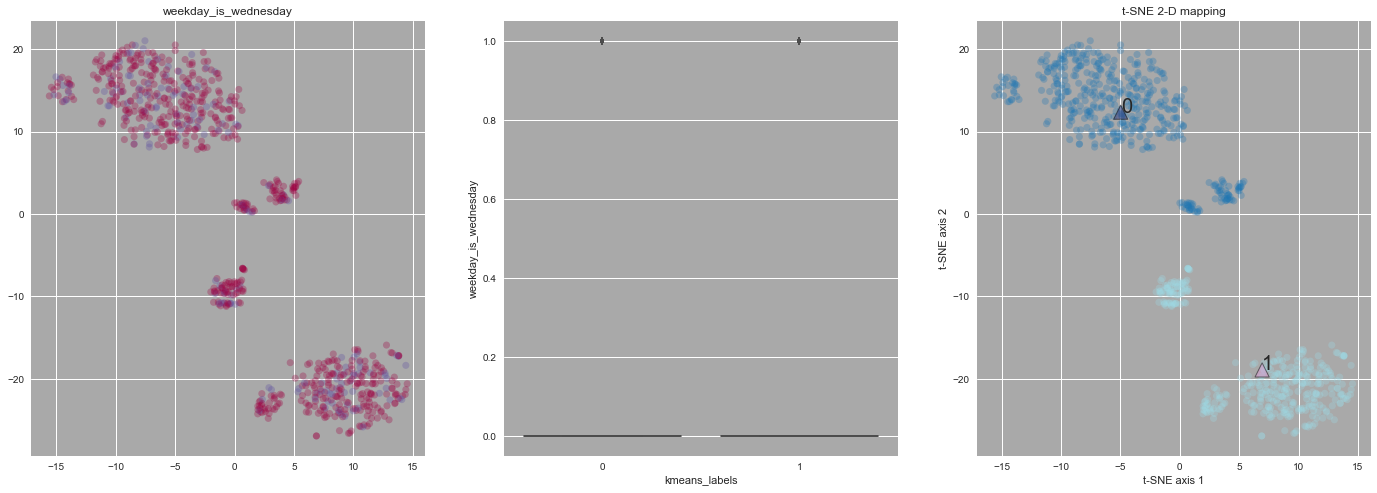

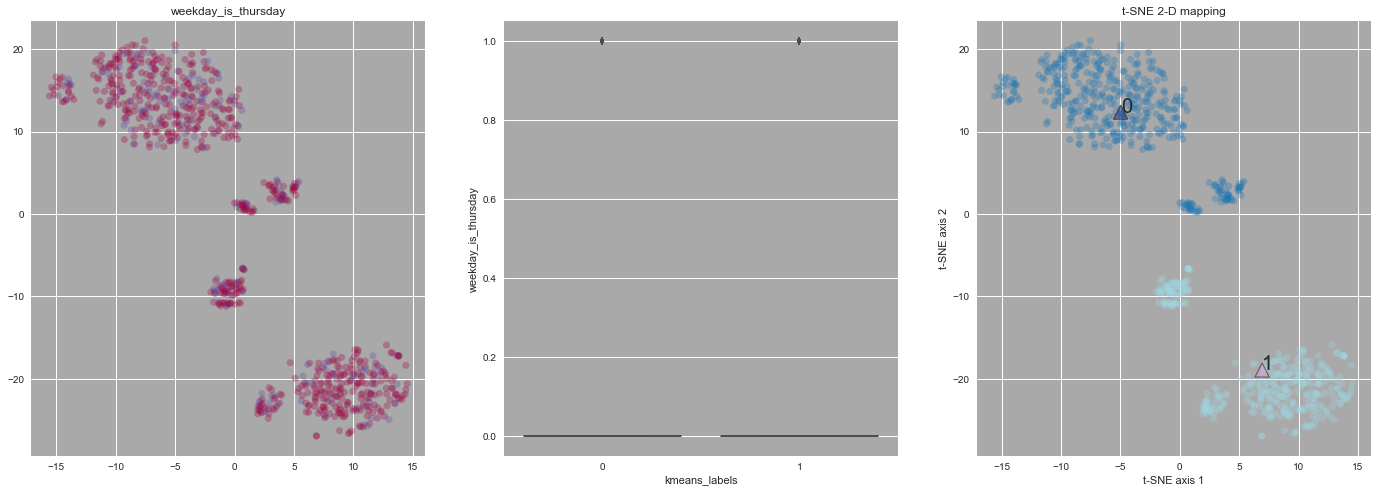

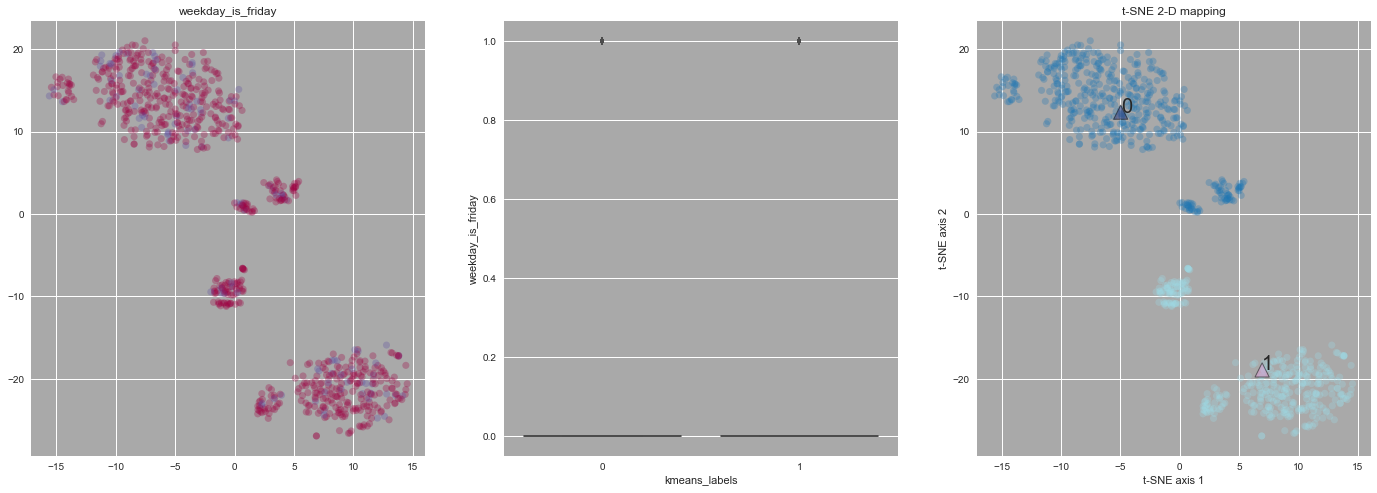

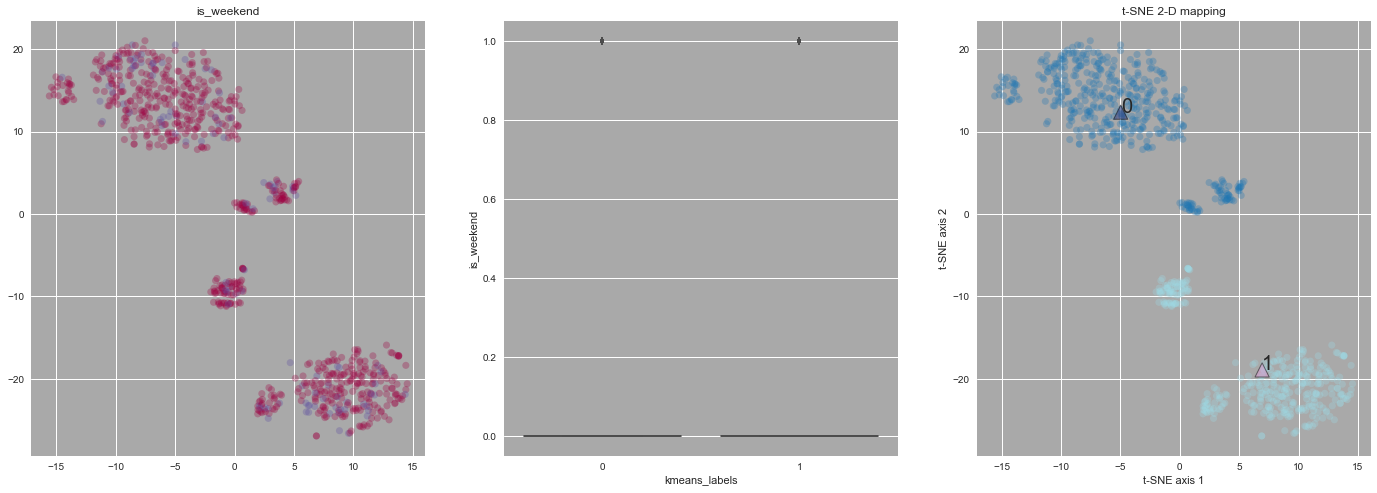

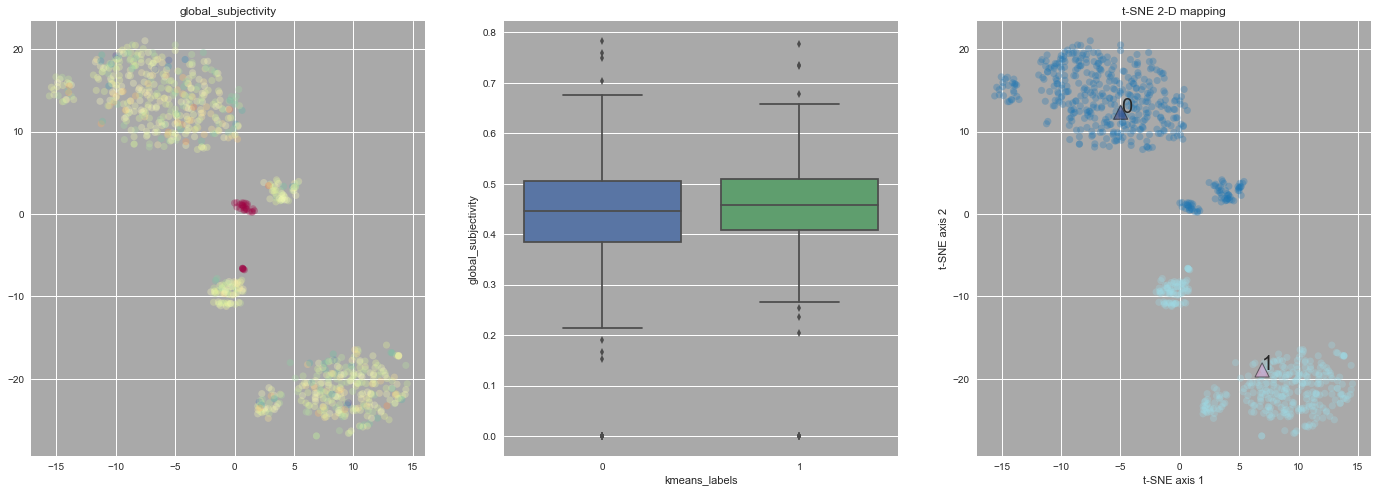

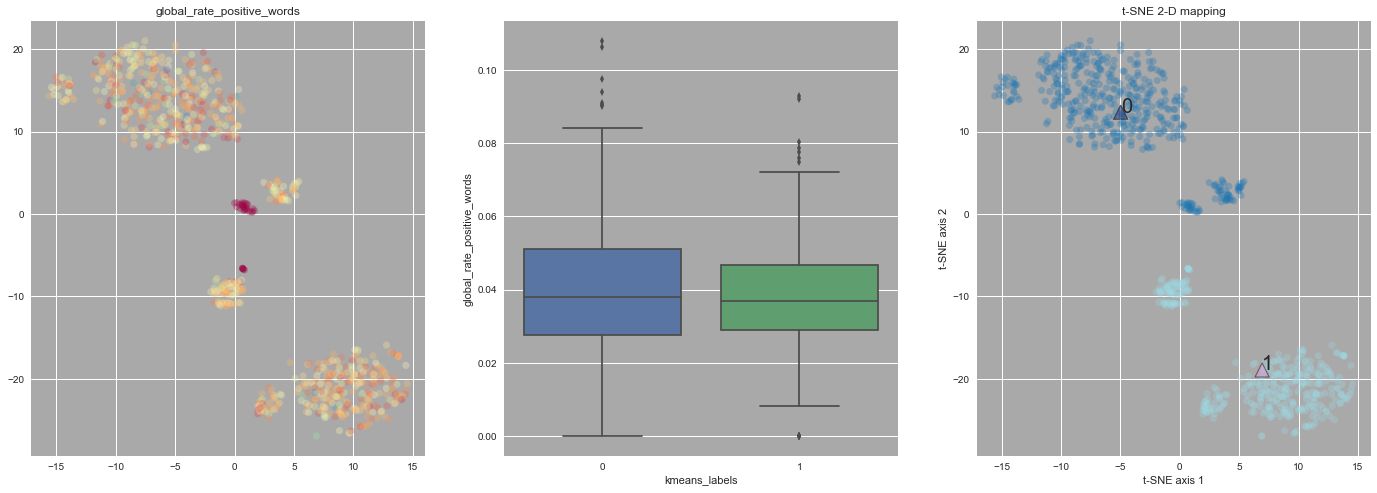

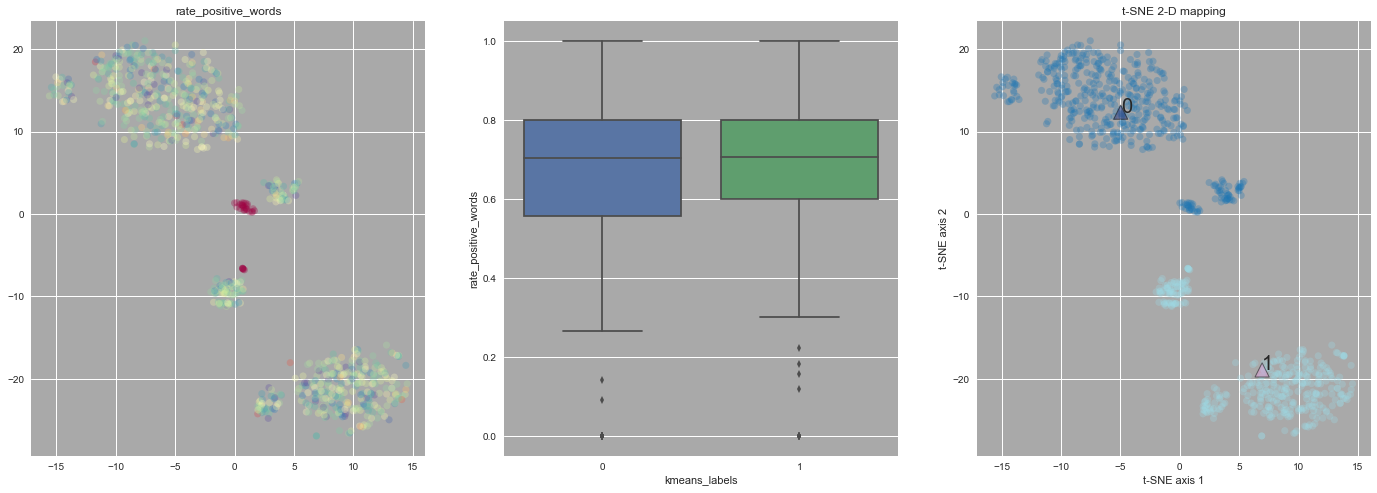

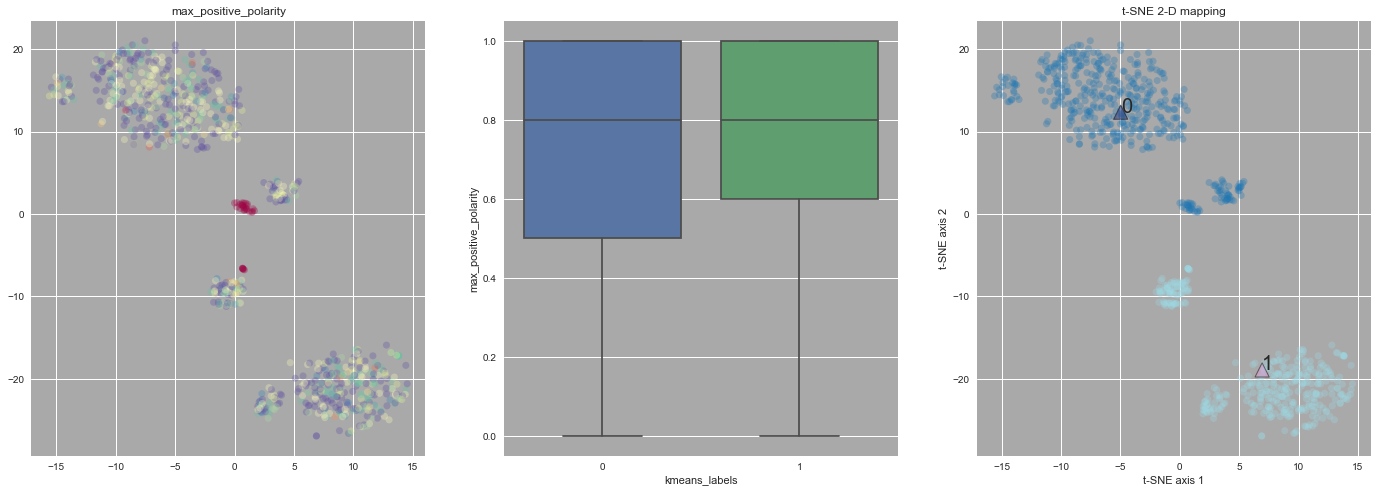

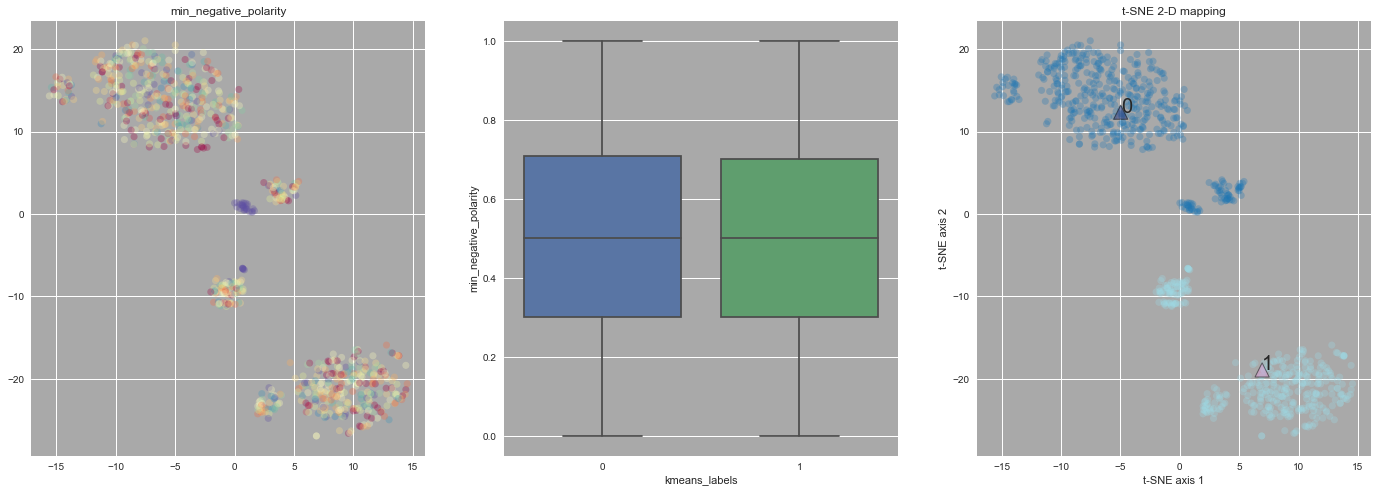

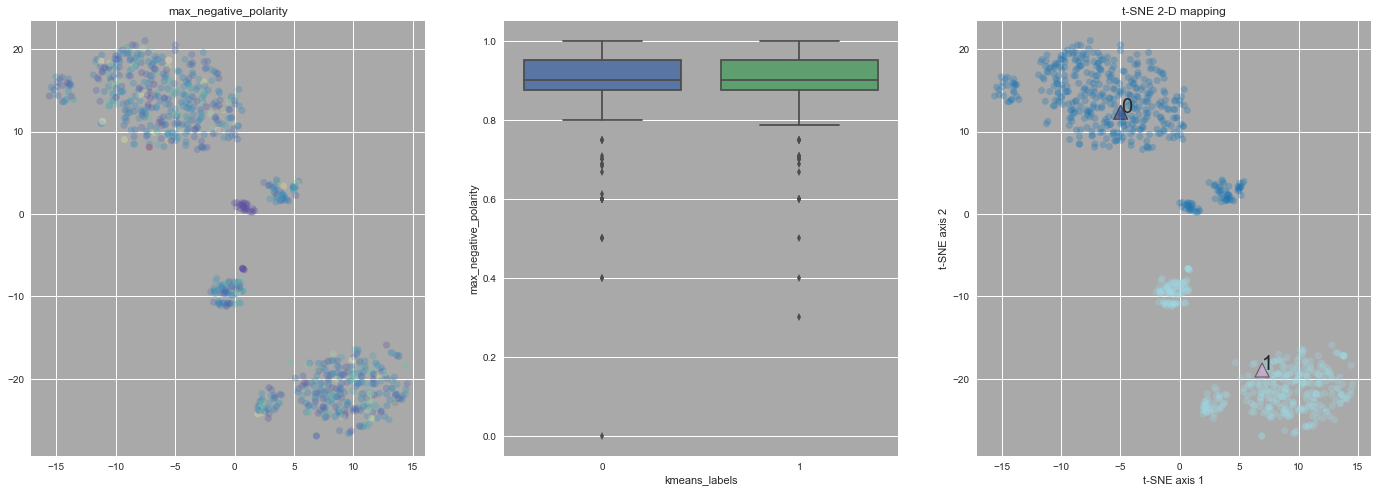

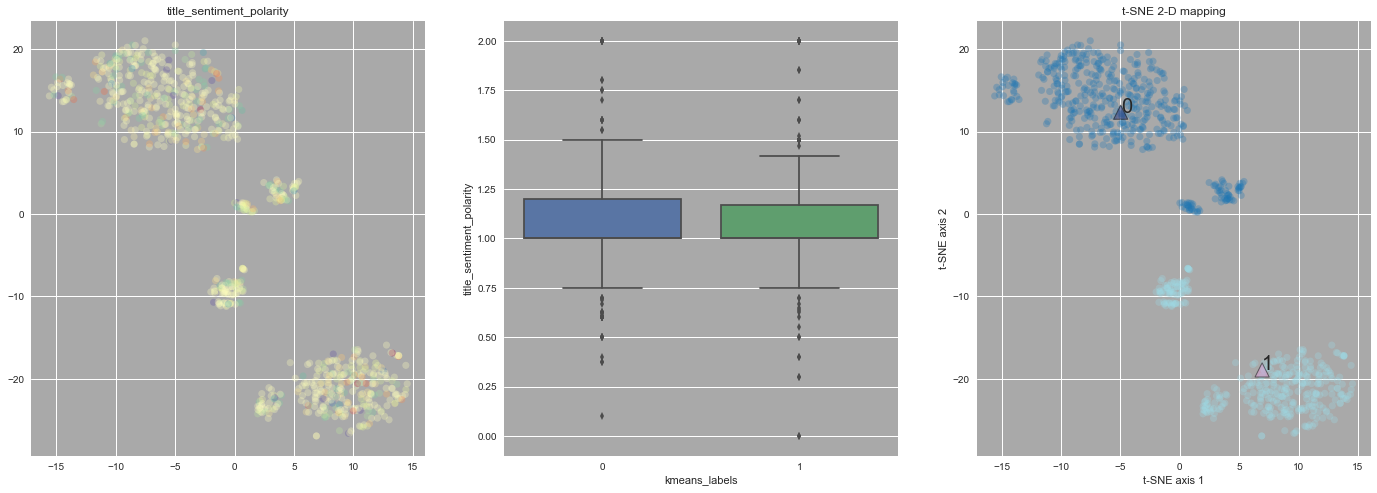

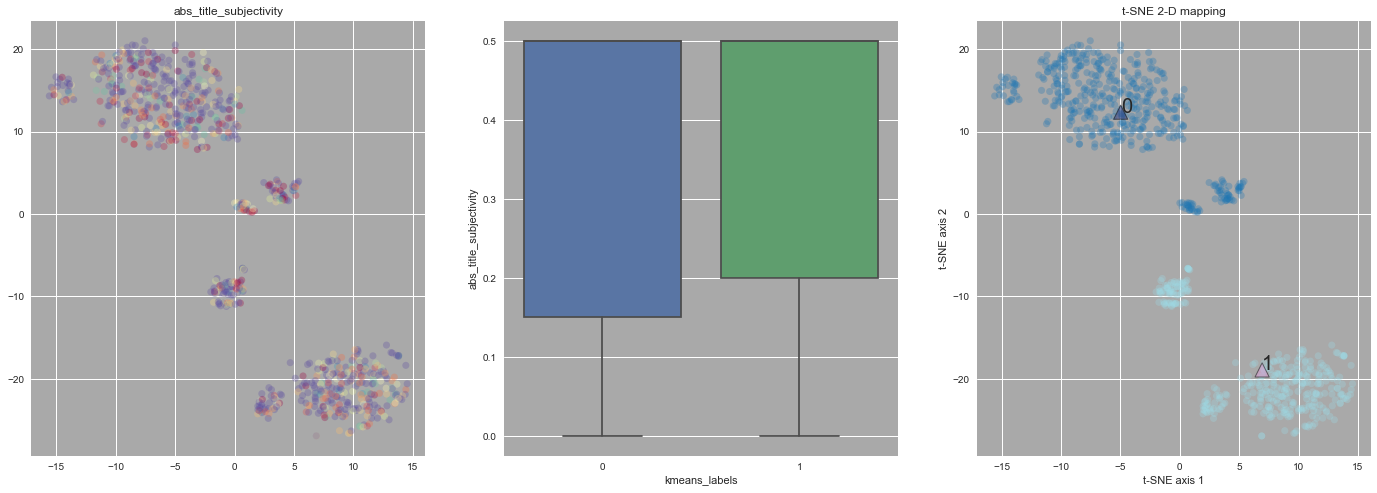

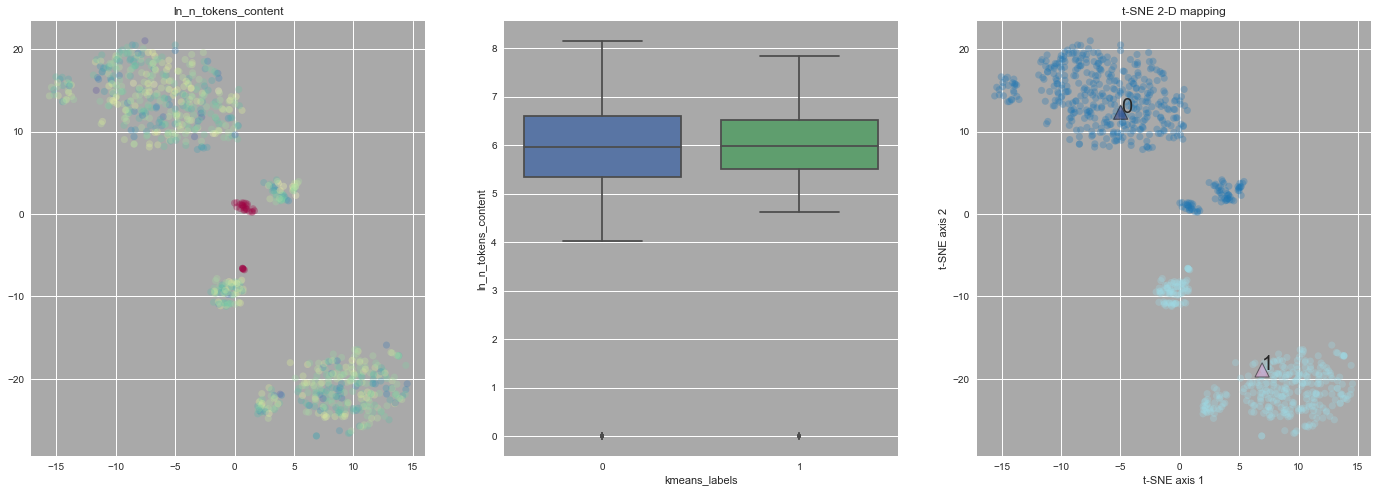

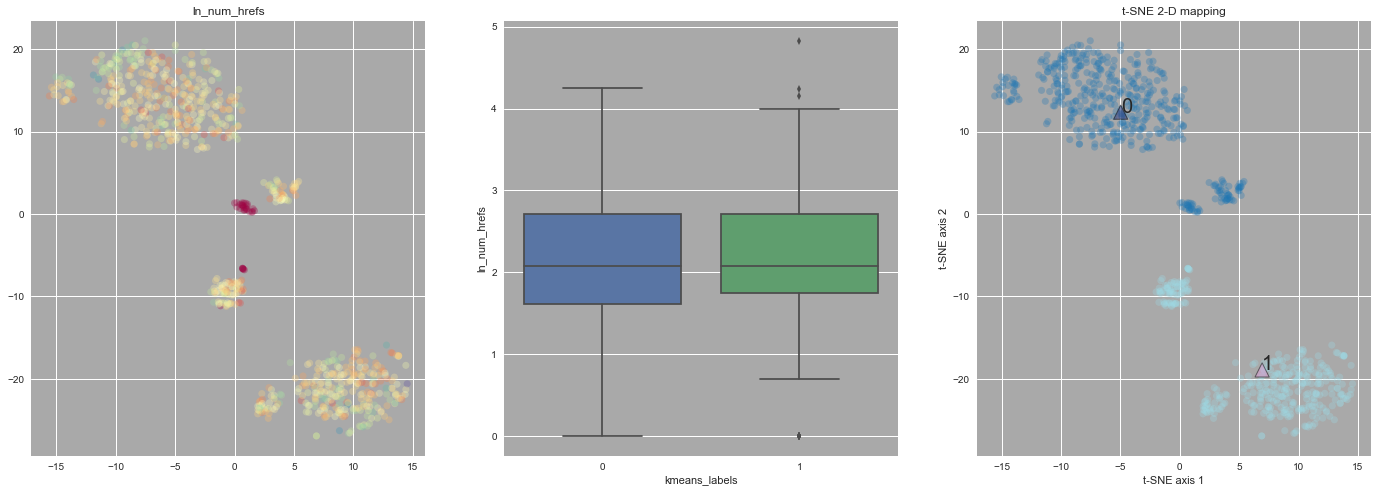

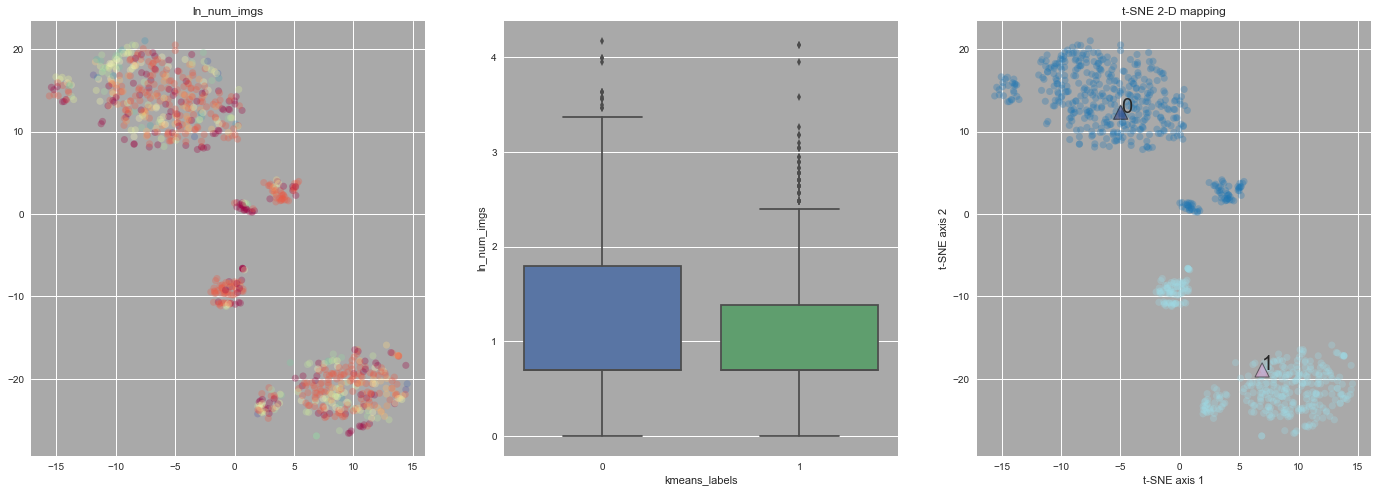

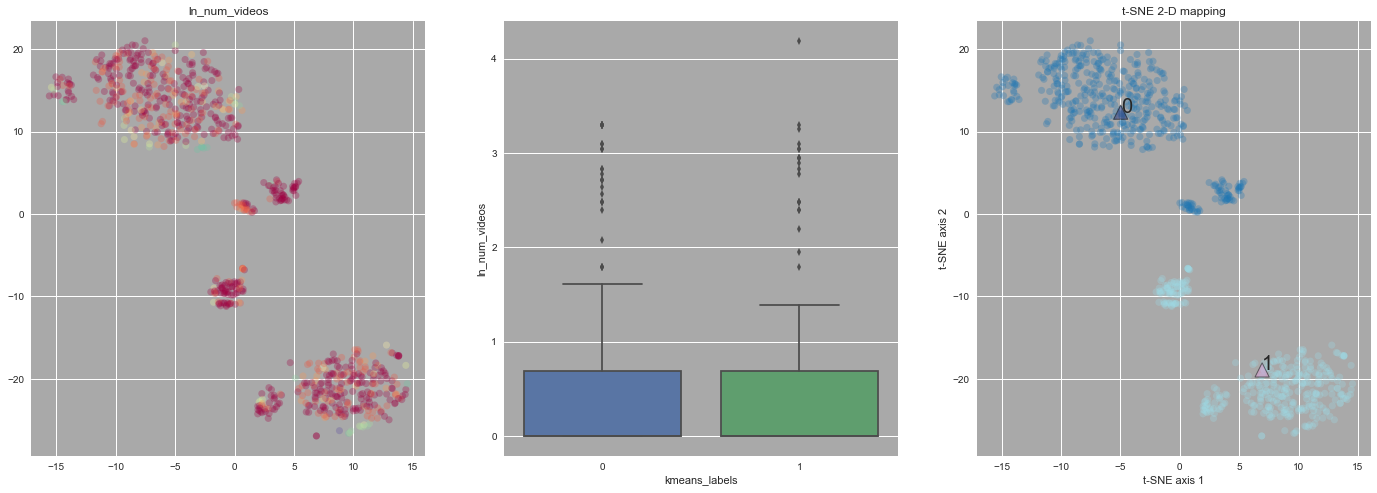

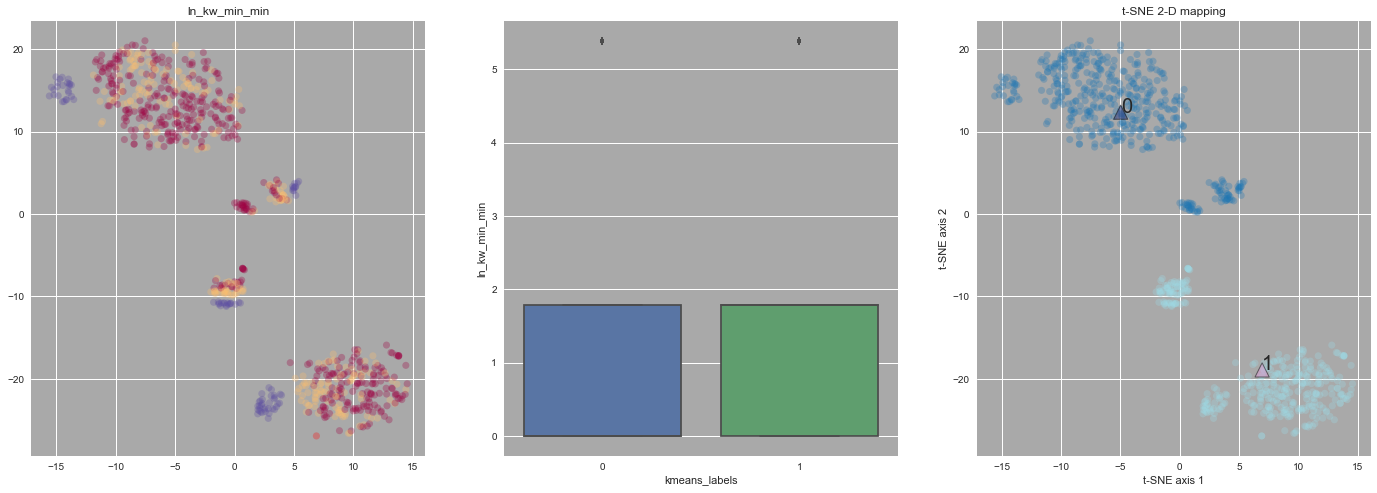

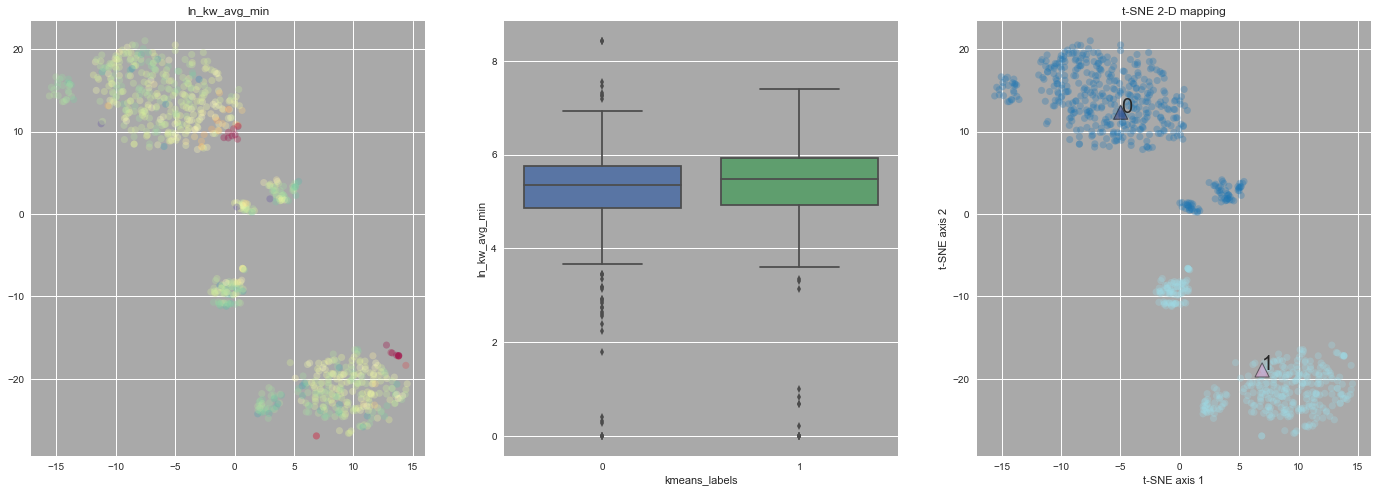

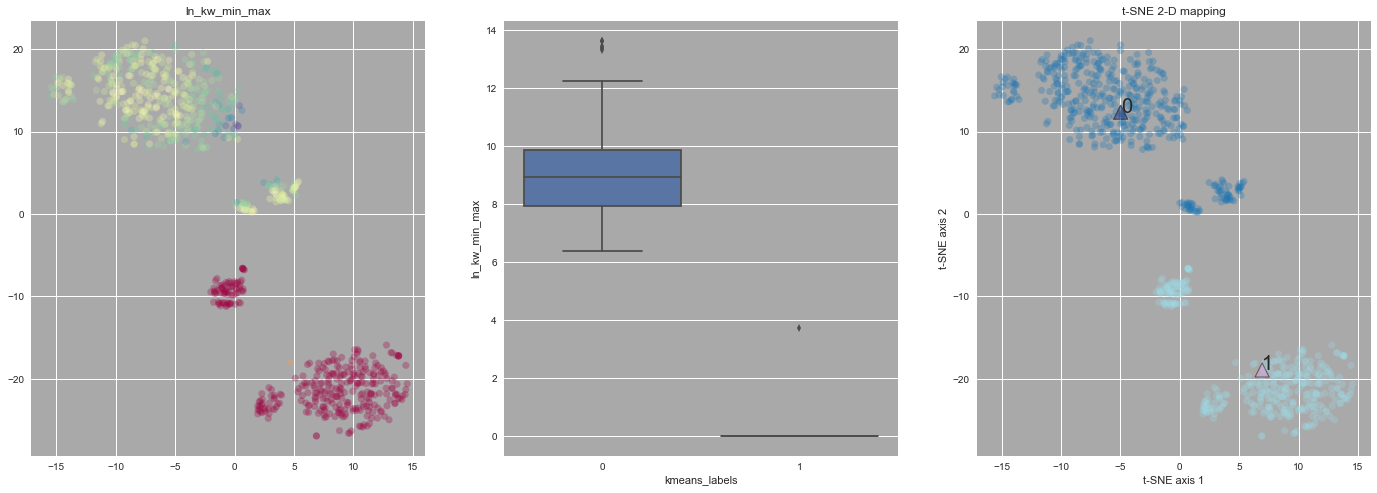

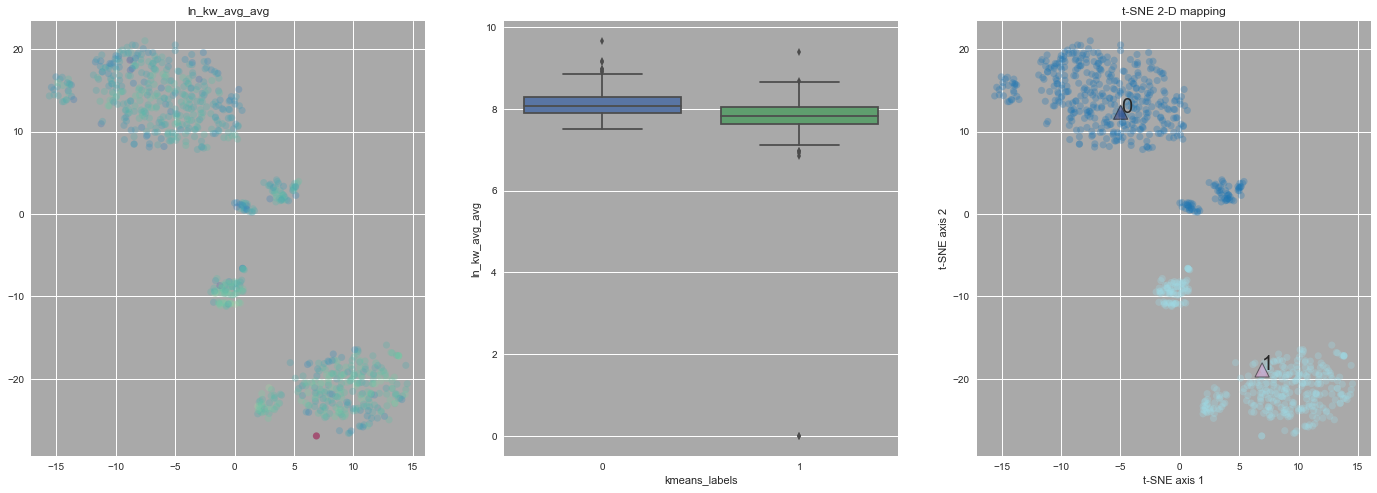

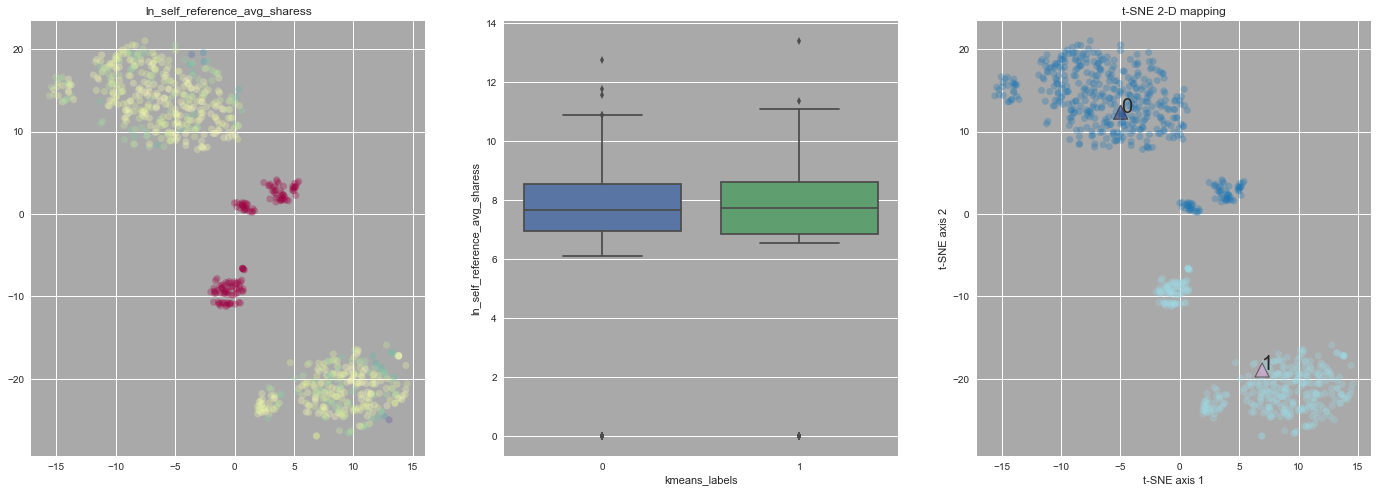

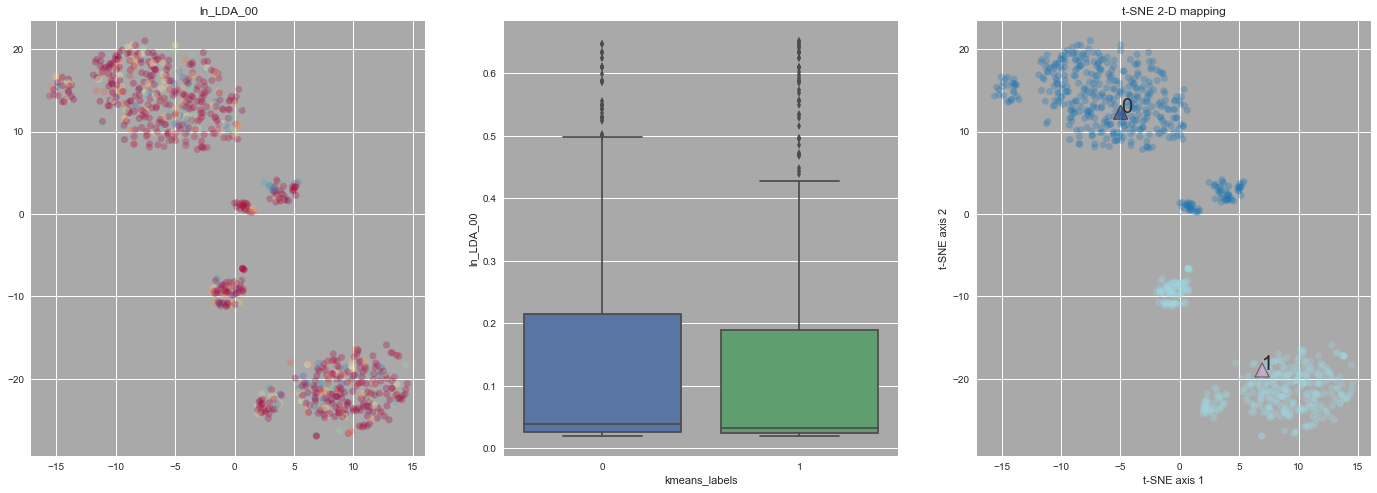

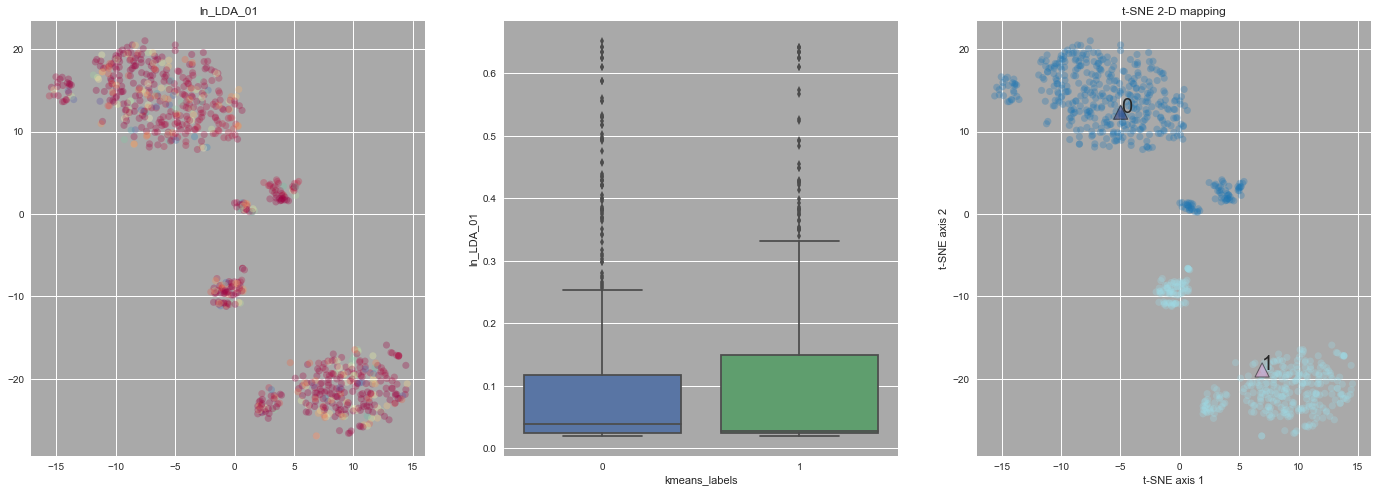

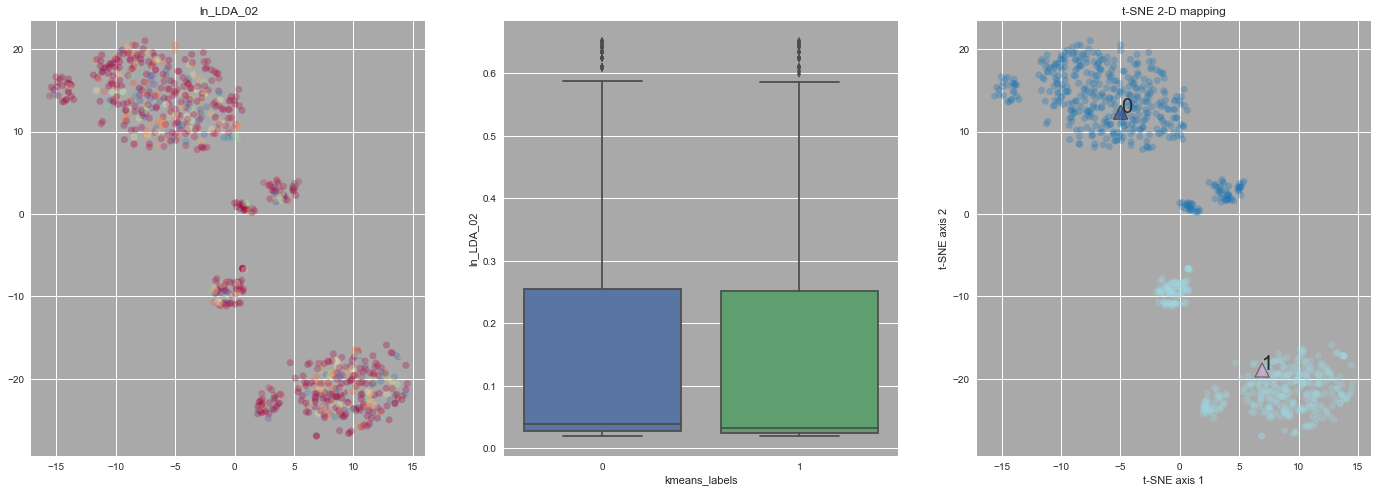

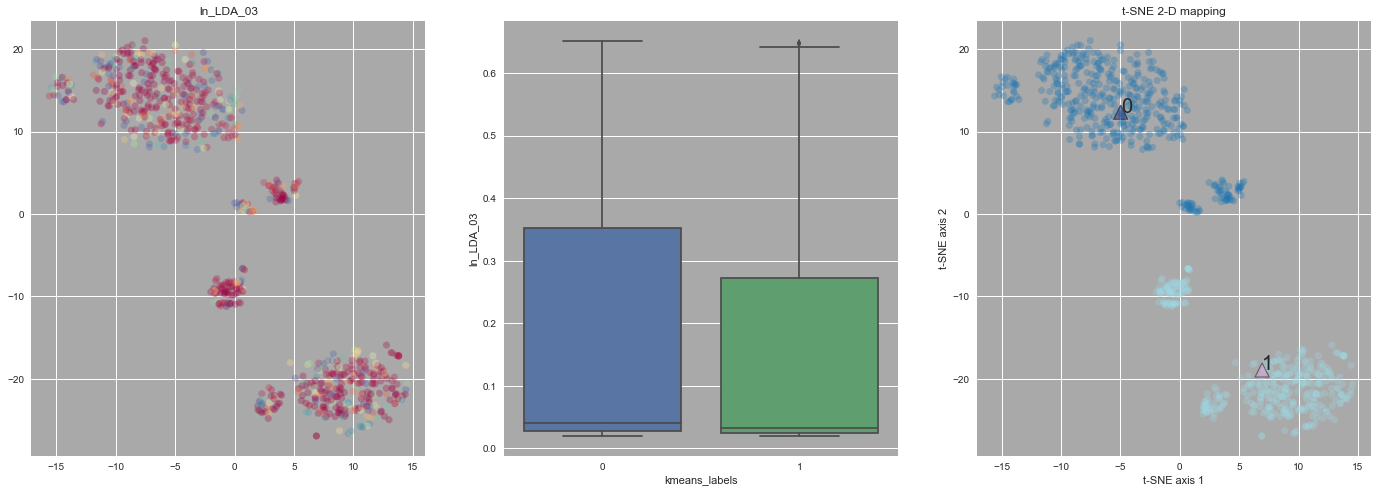

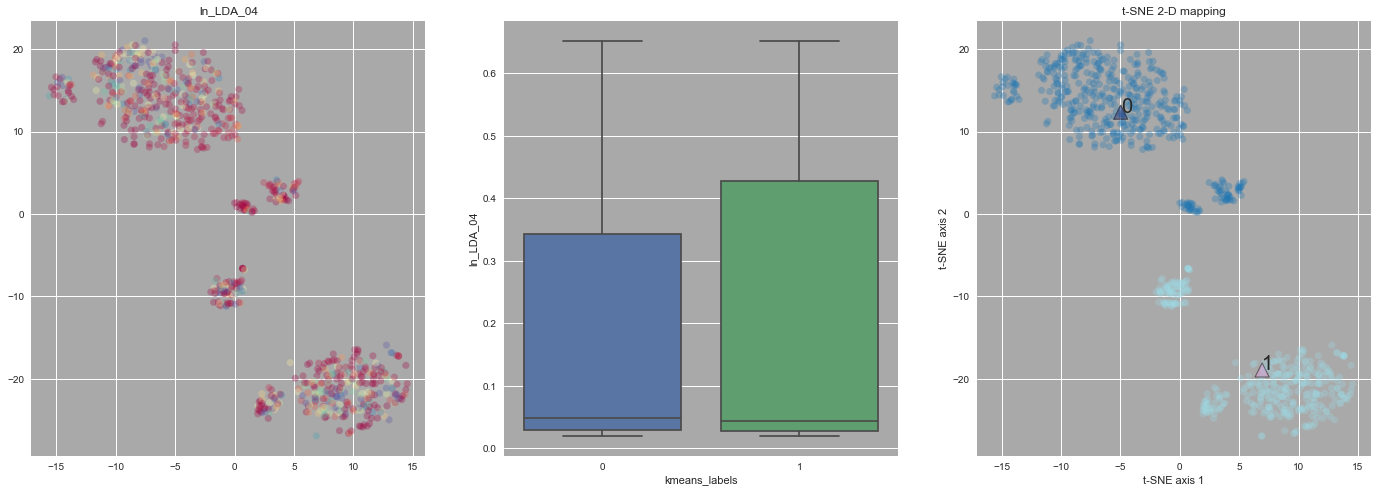

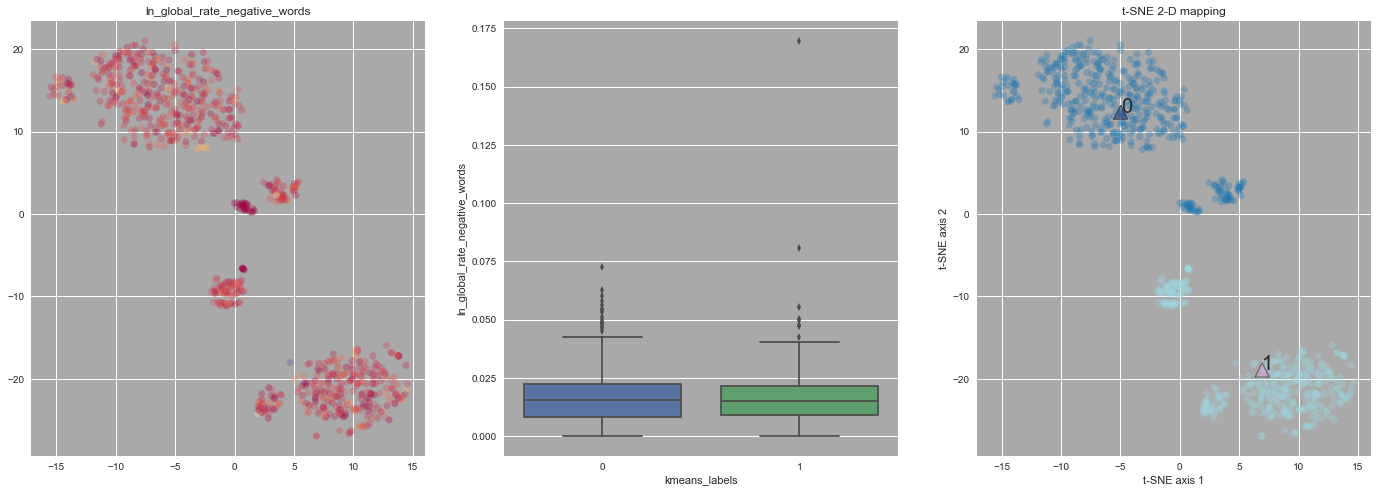

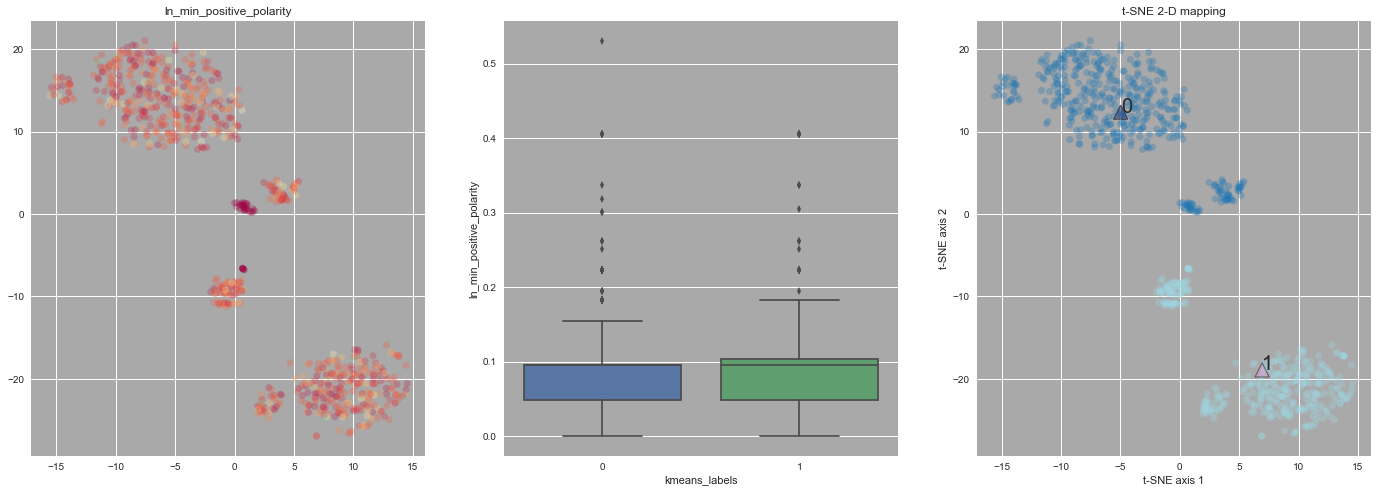

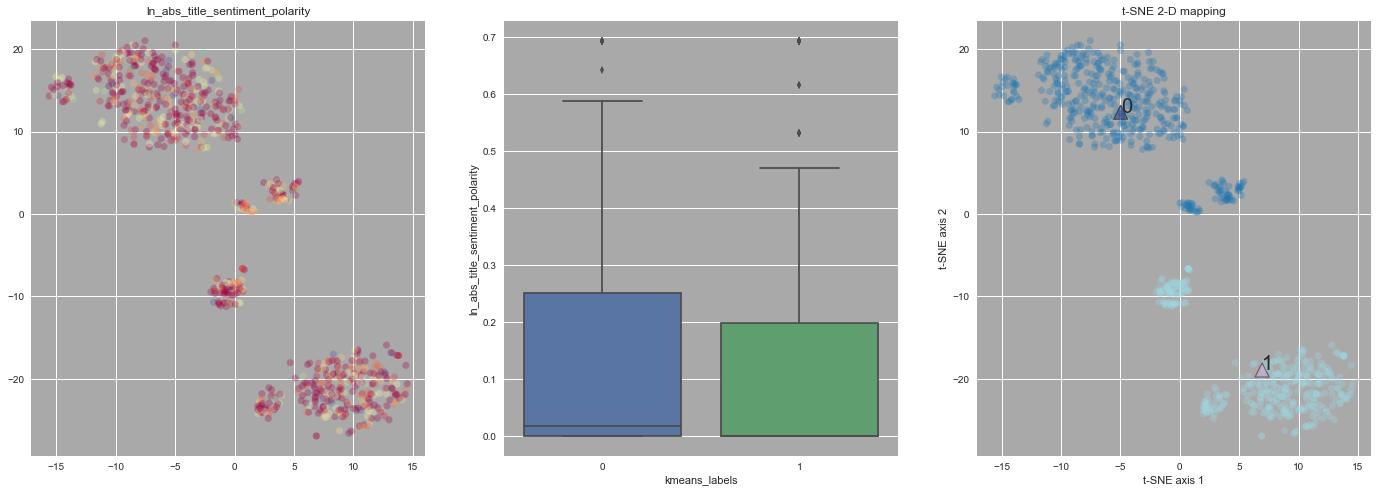

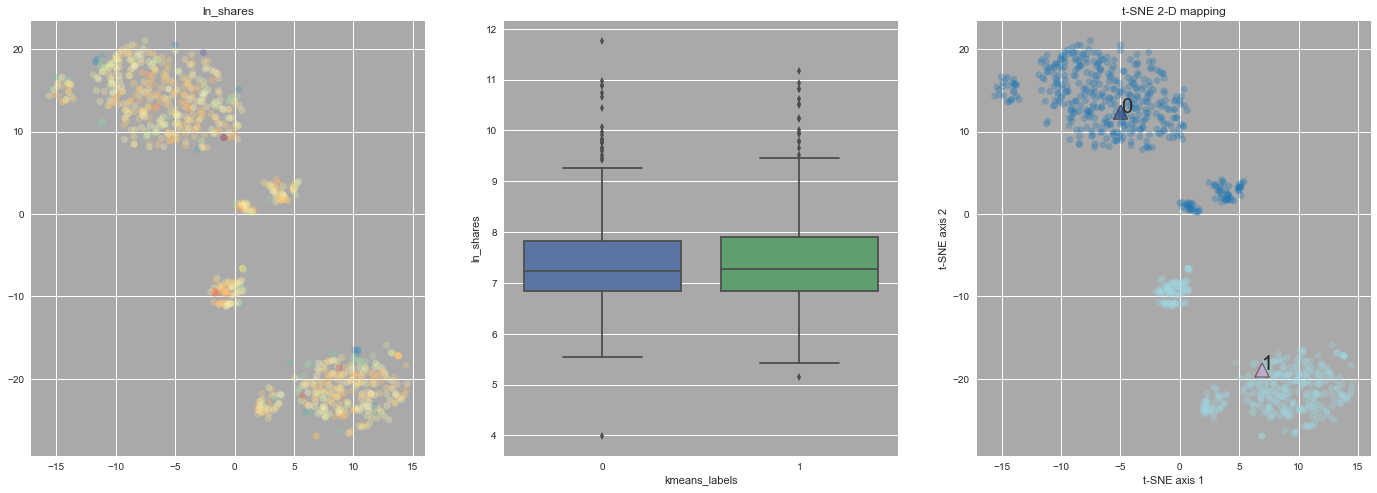

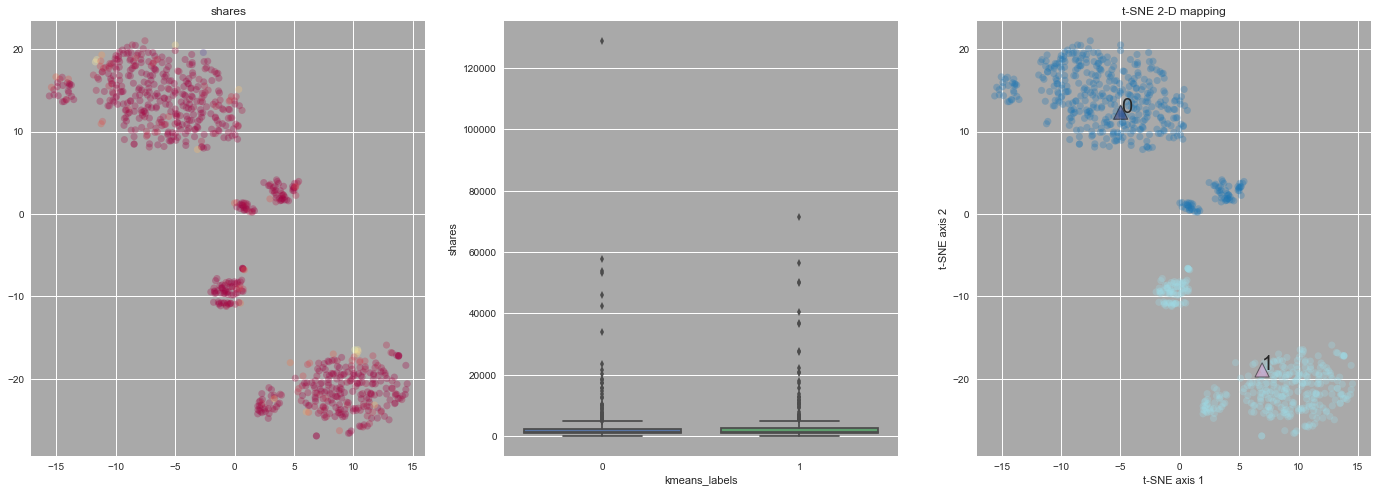

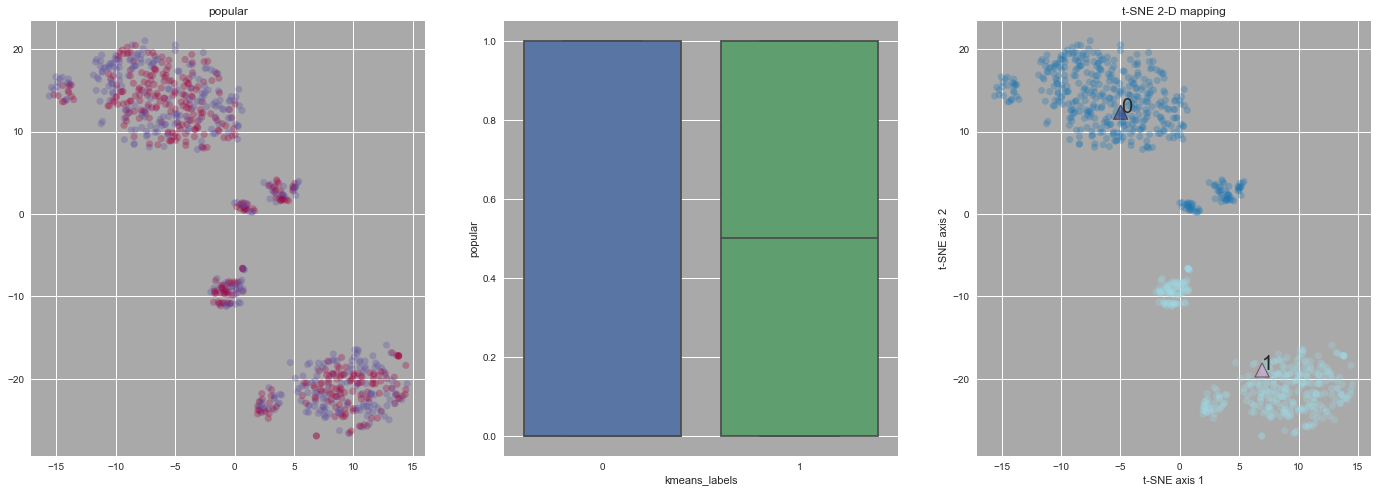

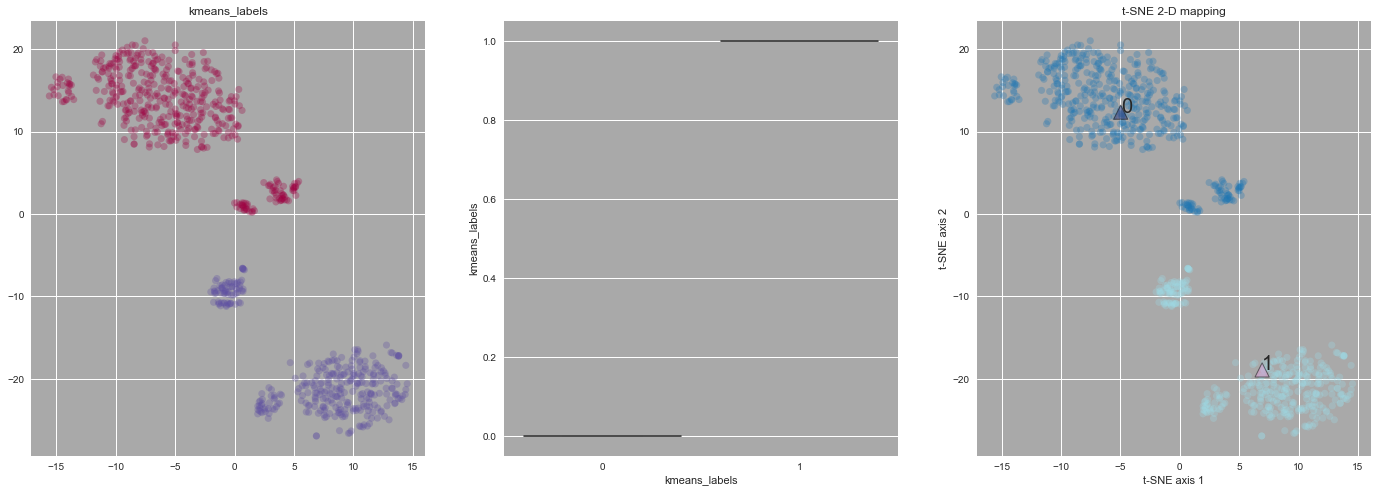

In [20]:
# boxplot across clusters for each feature ...
import seaborn as sns

col_names = X_all_together.columns.values.tolist()

for col in col_names :
    
    _ = plt.figure(figsize=(24, 8));
    
# ... feature distribution color map 

    _ = plt.subplot(131, facecolor = 'darkgrey');
    
    _ = plt.scatter(X_all_together['x-tsne'], X_all_together['y-tsne'],
                 c = X_all_together[col],
                 cmap = plt.cm.Spectral,
                 s = 50,
                 linewidths = 0,
                 alpha = 0.30)
    _ = plt.title(col)
    
# ... feature boxplots

    _ = plt.subplot(132, facecolor = 'darkgrey');
    sns.boxplot(x = "kmeans_labels", y = col, data = X_all_together);

# ... cluster color map
    
    _ = plt.subplot(133, facecolor = 'darkgrey');
    
    _ = plt.scatter(X_all_together['x-tsne'], X_all_together['y-tsne'],
                 c = kmeans_labels,
                 cmap = plt.cm.tab20,
                 s = 50,
                 linewidths = 0,
                 alpha = 0.30)
    _ = plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1],
                c = range(n_lda),
                cmap = plt.cm.tab20b,
                s = 200,
                linewidths = 1.0,
                marker = '^',
                edgecolors = 'black',
                alpha = 0.50);    
    for ii in range(n_lda) :                                       
        _ = plt.text(kmeans_centers[ii, 0], kmeans_centers[ii, 1], ii, fontsize = 20)
        
    _ = plt.xlabel('t-SNE axis 1')
    _ = plt.ylabel('t-SNE axis 2')
    _ = plt.title('t-SNE 2-D mapping')
 
    _ = plt.show();
    

<a href='#toc'> Table of Contents</a>

<a name='end_of_file'></a>
<font color="blue" size=3>  end of file